## Problem Statement

At some point or the other almost each one of us has used an Ola or Uber for taking a ride. 

Ride hailing services are services that use online-enabled platforms to connect between passengers and local drivers using their personal vehicles. In most cases they are a comfortable method for door-to-door transport. Usually they are cheaper than using licensed taxicabs. Examples of ride hailing services include Uber and Lyft.


To improve the efficiency of taxi dispatching systems for such services, it is important to be able to predict how long a driver will have his taxi occupied. If a dispatcher knew approximately when a taxi driver would be ending their current ride, they would be better able to identify which driver to assign to each pickup request.

In this competition, we are challenged to build a model that predicts the total ride duration of taxi trips in New York City.

In [152]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from haversine import haversine
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


In [153]:
#import the data from a csv file.
path ="nyc_taxi_trip_duration.csv"
nyc_df =  pd.read_csv(path)

In [154]:
print('We have {} rows.'.format(nyc_df.shape[0]))
print('We have {} columns'.format(nyc_df.shape[1]))

We have 729322 rows.
We have 11 columns


In [155]:
nyc_df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

## 1. Idendifying Variables
Let's check the data files! According to the data description we should find the following columns:

 - **id** - a unique identifier for each trip
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - (target) duration of the trip in seconds

Here, we have 2 variables dropoff_datetime and store_and_fwd_flag which are not available before the trip starts and hence will not be used as features to the model.

In [156]:
nyc_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,7.293220e+05
mean,1.535403,1.662055,-73.973513,40.750919,-73.973422,40.751775,9.522291e+02
std,0.498745,1.312446,0.069754,0.033594,0.069588,0.036037,3.864626e+03
min,1.000000,0.000000,-121.933342,34.712234,-121.933304,32.181141,1.000000e+00
25%,1.000000,1.000000,-73.991859,40.737335,-73.991318,40.735931,3.970000e+02
50%,2.000000,1.000000,-73.981758,40.754070,-73.979759,40.754509,6.630000e+02
75%,2.000000,2.000000,-73.967361,40.768314,-73.963036,40.769741,1.075000e+03
max,2.000000,9.000000,-65.897385,51.881084,-65.897385,43.921028,1.939736e+06


### Missing Values
Knowing about missing values is important because they indicate how much we don’t know about our data. Making inferences based on just a few cases is often unwise. In addition, many modelling procedures break down when missing values are involved and the corresponding rows will either have to be removed completely or the values need to be estimated somehow.

In [157]:
nyc_df.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [158]:
#Check for duplicated values
nyc_df.drop_duplicates(inplace=True)
nyc_df.shape

(729322, 11)

### Reformatting features & Checking consistency
There are a variety of features within the dataset and it is important to convert them into the right format such that we can analyse them easily. This would include converting datetime features and string features. 

Also, one important thing is never to take assumptions without backing it with data. Here, as you can see the trip duration can also be calculated pick up and drop off datetime. We will check whether the given duration is consistent with the calculated trip duration 

In [159]:
#Convert timestamp to datetime format to fetch the other details as listed below
nyc_df['pickup_datetime']=pd.to_datetime(nyc_df['pickup_datetime'])
nyc_df['dropoff_datetime']=pd.to_datetime(nyc_df['dropoff_datetime'])

In [160]:
#Calculate and assign new columns to the dataframe such as pickupday,
#dropoffday which will help us to gain more insights from the data.
nyc_df['pickup_day']=nyc_df['pickup_datetime'].dt.day_name()
nyc_df['dropoff_day']=nyc_df['dropoff_datetime'].dt.day_name()

In [161]:
# Dropping the feature created 
nyc_df.drop(['pickup_day'],axis=1,inplace=True)
nyc_df.drop(['dropoff_day'],axis=1,inplace=True)

In [162]:
#Calculate and assign new columns to the dataframe such as year,
#month ,day_num,hour and minute which will help us to gain more insights from the data.
nyc_df['pickup_weekday'] = nyc_df.pickup_datetime.dt.day_name()
nyc_df['dropoff_weekday'] = nyc_df.dropoff_datetime.dt.day_name()
nyc_df['month'] = nyc_df.pickup_datetime.dt.month
nyc_df['weekday_num'] = nyc_df.pickup_datetime.dt.weekday
nyc_df['pickup_hour'] = nyc_df.pickup_datetime.dt.hour
nyc_df['dropoff_hour'] = nyc_df.dropoff_datetime.dt.hour

In [163]:
nyc_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,dropoff_weekday,month,weekday_num,pickup_hour,dropoff_hour
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400,Monday,Monday,2,0,16,16
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100,Friday,Friday,3,4,23,23
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635,Sunday,Sunday,2,6,17,18
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141,Tuesday,Tuesday,1,1,9,10
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848,Wednesday,Wednesday,2,2,6,6


In [164]:
# creating a function that will out trip duration from pick and dropoff time
def calculate_trip_duration(pickup,dropoff):
    return (dropoff-pickup).total_seconds()

In [165]:
# creating a feature which stores this calculated trip duration
nyc_df['calculate_trip_duration']=nyc_df.apply(lambda x: calculate_trip_duration(x['pickup_datetime'],x['dropoff_datetime']),axis=1)

In [166]:
nyc_df.trip_duration.count()

729322

In [167]:
# checking for consistency by comparing trip duration with calculated trip duration
(nyc_df['calculate_trip_duration']==nyc_df['trip_duration']).value_counts()

True    729322
dtype: int64

In [168]:
# Dropping the feature created 
nyc_df.drop(['calculate_trip_duration'],axis=1,inplace=True)

 ### FEATURE ENGINEERING

Feature engineering is a machine learning technique that leverages data to create new variables that aren’t in the training set. It can produce new features for both supervised and unsupervised learning, with the goal of simplifying and speeding up data transformations while also enhancing model accuracy.

In [169]:
#calc_distance is a function to calculate distance between pickup and dropoff coordinates using Haversine formula.
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

In [170]:
#Calculate distance and assign new column to the dataframe.
nyc_df["distance"] = nyc_df.apply(lambda x: calc_distance(x),axis=1)

In [171]:
nyc_df['speed'] = (nyc_df.distance/(nyc_df.trip_duration/3600))

In [172]:
numerical_col = nyc_df.select_dtypes([int,float]).columns
numerical_col

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration', 'month',
       'weekday_num', 'pickup_hour', 'dropoff_hour', 'distance', 'speed'],
      dtype='object')

### Descriptive analysis

In [173]:
_columns = [ 'MIn', 'Max', 'Mean', 'median', 'stddev', 'variance']
_index = []
data1 = []
for i in numerical_col:
    _index.append(i)
    data1.append([nyc_df[i].min(), nyc_df[i].max(), round(nyc_df[i].mean(),2), round(nyc_df[i].median(),2), round(nyc_df[i].std(),2), round(nyc_df[i].var(),2)])

print(pd.DataFrame(data1,index=_index, columns=_columns))

                          MIn           Max    Mean  median   stddev  \
vendor_id            1.000000  2.000000e+00    1.54    2.00     0.50   
passenger_count      0.000000  9.000000e+00    1.66    1.00     1.31   
pickup_longitude  -121.933342 -6.589738e+01  -73.97  -73.98     0.07   
pickup_latitude     34.712234  5.188108e+01   40.75   40.75     0.03   
dropoff_longitude -121.933304 -6.589738e+01  -73.97  -73.98     0.07   
dropoff_latitude    32.181141  4.392103e+01   40.75   40.75     0.04   
trip_duration        1.000000  1.939736e+06  952.23  663.00  3864.63   
month                1.000000  6.000000e+00    3.52    4.00     1.68   
weekday_num          0.000000  6.000000e+00    3.05    3.00     1.95   
pickup_hour          0.000000  2.300000e+01   13.61   14.00     6.40   
dropoff_hour         0.000000  2.300000e+01   13.61   14.00     6.49   
distance             0.000000  1.240910e+03    3.44    2.10     4.35   
speed                0.000000  5.640502e+03   14.42   12.80    1

### Ploting Outliers

In [174]:
# plot a boxplot for the label by each numerical feature  
def plot_outliers(data, var_group):

    # set number of rows and columns for subplots
    num_rows = len(var_group) // 3 + 1
    num_cols = 3

    # create the subplots
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5*num_rows))

    # loop through the numerical columns and create a boxplot on each subplot
    for idx, col in enumerate(var_group):
        row_idx = idx // num_cols
        col_idx = idx % num_cols
        axs[row_idx, col_idx].boxplot(nyc_df[col])
        axs[row_idx, col_idx].set_title(col)

    # remove any empty subplots
    for idx in range(len(var_group), num_rows*num_cols):
        row_idx = idx // num_cols
        col_idx = idx % num_cols
        fig.delaxes(axs[row_idx, col_idx])

    plt.tight_layout()
    plt.show()

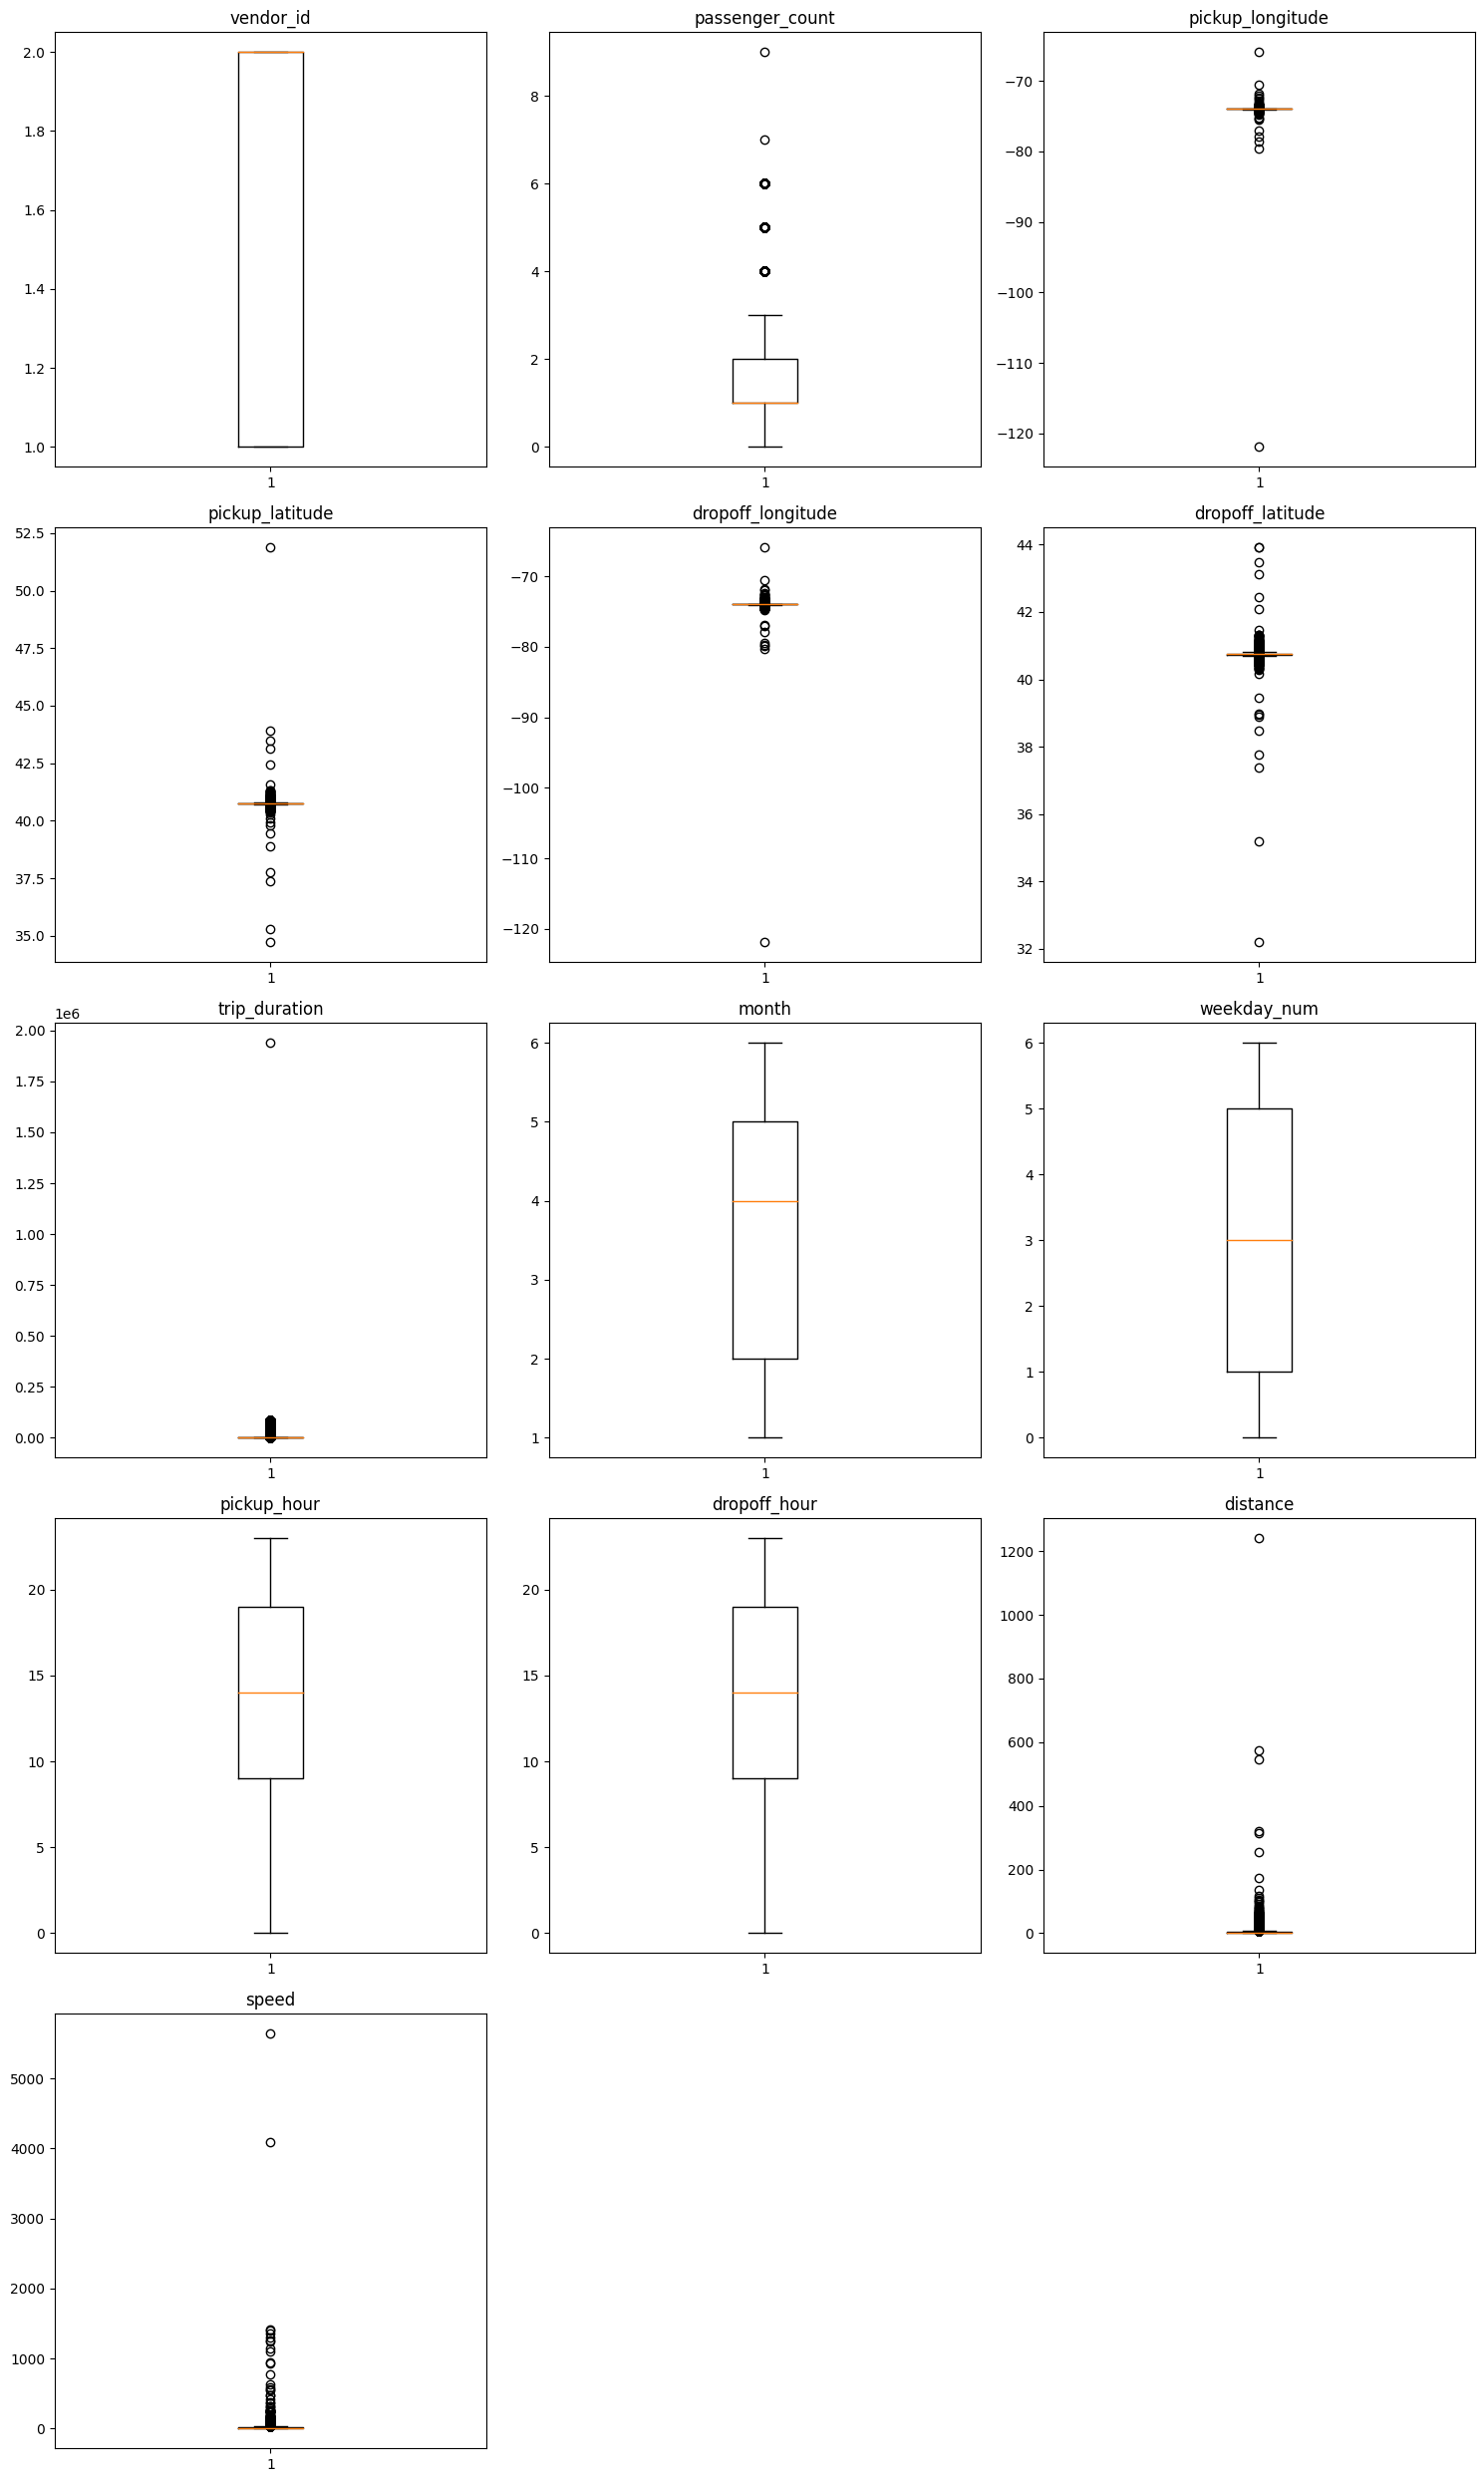

In [175]:
plot_outliers(nyc_df, numerical_col)

## Univariate Analysis

### Target Exploration
In this section we will take a look at the trip duration which is the target variable. It is crucial to understand it in detail as this is what we are trying to predict accurately.

C:\Users\vikas\AppData\Local\Temp\ipykernel_3240\2066773249.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nyc_df['trip_duration'],color="b").set(title='Distribution Plot for Trip Duration')


[Text(0.5, 1.0, 'Distribution Plot for Trip Duration')]

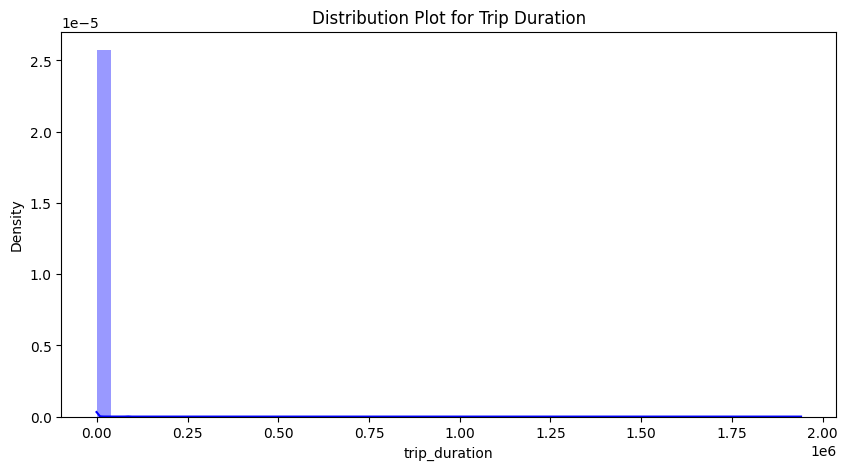

In [176]:
#Dependent variable 'trip_duration'
plt.figure(figsize=(10,5))
sns.distplot(nyc_df['trip_duration'],color="b").set(title='Distribution Plot for Trip Duration')

C:\Users\vikas\AppData\Local\Temp\ipykernel_3240\641220408.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(nyc_df['trip_duration']),color="r").set(title='Distribution Plot with Log Transformation for Trip Duration')


[Text(0.5, 1.0, 'Distribution Plot with Log Transformation for Trip Duration')]

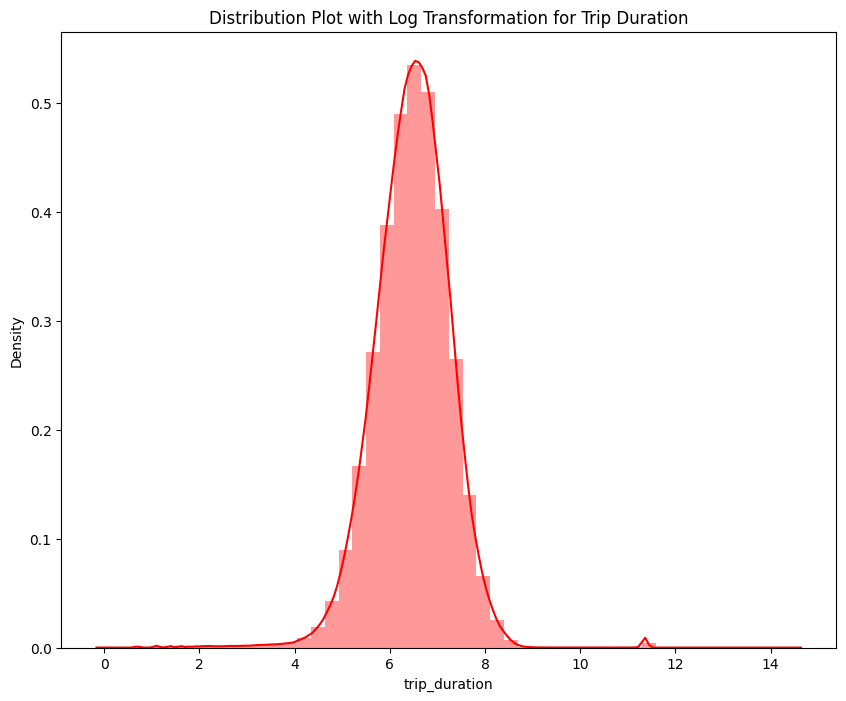

In [177]:
plt.figure(figsize=(10,8))
sns.distplot(np.log(nyc_df['trip_duration']),color="r").set(title='Distribution Plot with Log Transformation for Trip Duration')

We find:

1. The majority of rides follow a rather smooth distribution that looks almost log-normal with a peak just around exp(6.5)  i.e. about 17 minutes.
2. There are several suspiciously short rides with less than 10 seconds duration.
3. As discussed earlier, there are a few huge outliers near 12.

## Time related analysis

### Pickup/Dropoff frequency by Hours

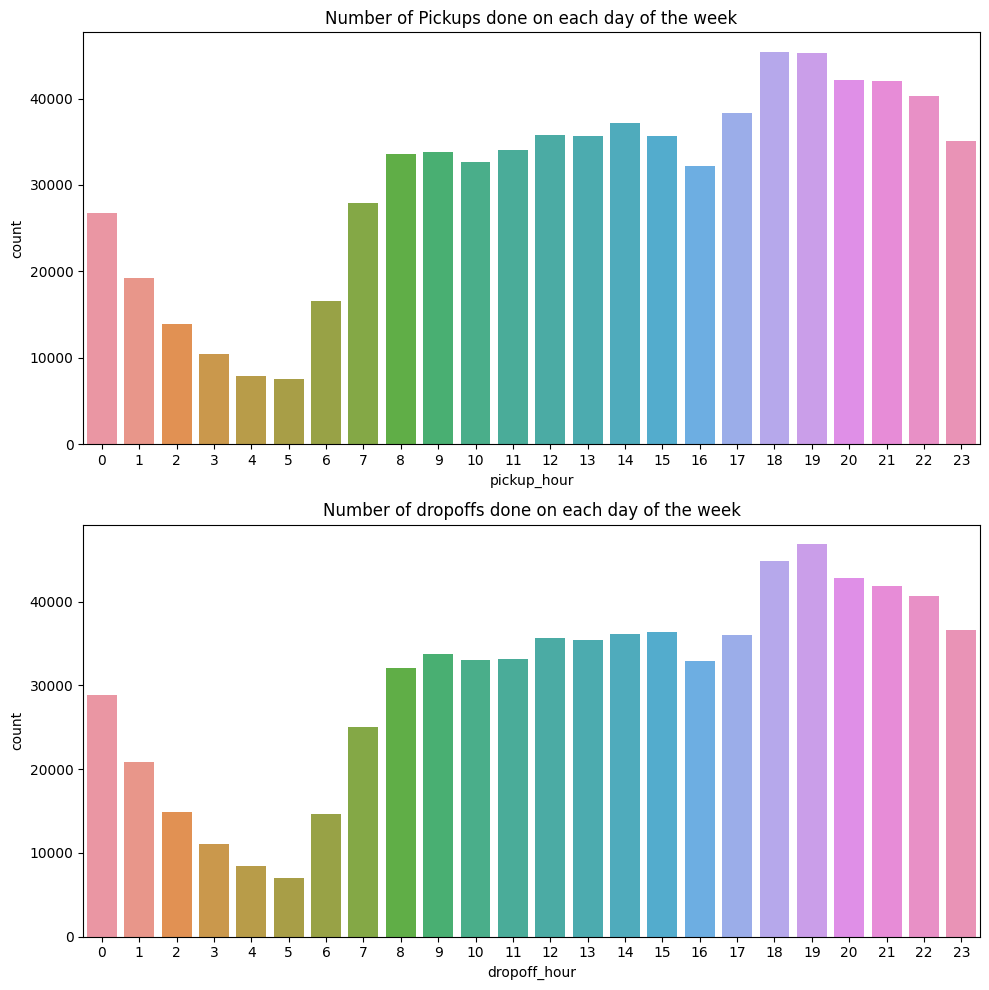

In [178]:
#Number of Pickups and Dropoff on each day of the week
figure,ax=plt.subplots(nrows=2,ncols=1,figsize=(10,10))
sns.countplot(x='pickup_hour',data=nyc_df,ax=ax[0])
ax[0].set_title('Number of Pickups done by hours')
sns.countplot(x='dropoff_hour',data=nyc_df,ax=ax[1])
ax[1].set_title('Number of dropoffs done by hours')

plt.tight_layout()

### trip count Distribution by port of Day

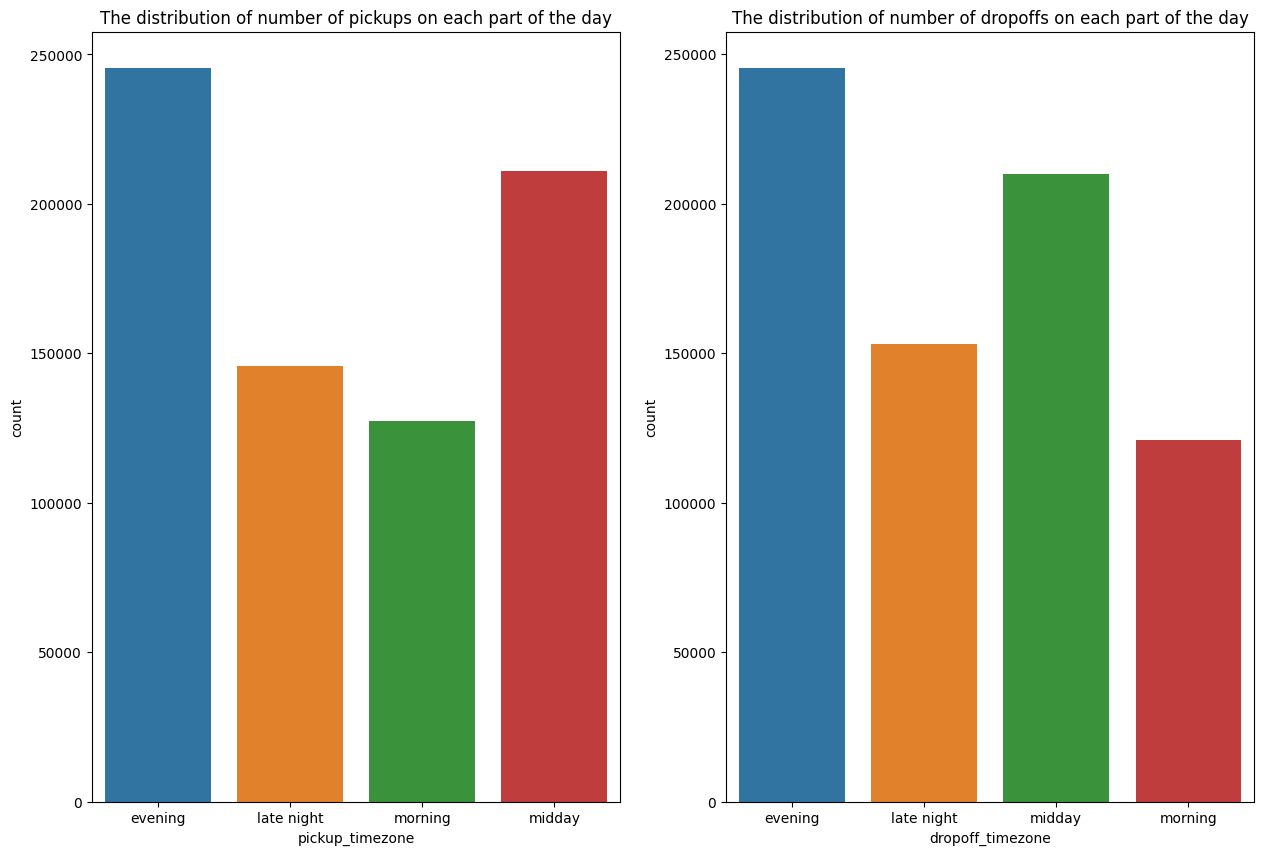

In [179]:
import datetime

bins=np.array([0,1800,3600,5400,7200,90000])
nyc_df['duration_time']=pd.cut(nyc_df.trip_duration,bins,labels=["< 5", "5-10", "10-15","15-20",">20"])

def timezone(x):
    if x>=datetime.time(4, 0, 1) and x <=datetime.time(10, 0, 0):
        return 'morning'
    elif x>=datetime.time(10, 0, 1) and x <=datetime.time(16, 0, 0):
        return 'midday'
    elif x>=datetime.time(16, 0, 1) and x <=datetime.time(22, 0, 0):
        return 'evening'
    elif x>=datetime.time(22, 0, 1) or x <=datetime.time(4, 0, 0):
        return 'late night'
    
nyc_df['pickup_timezone']=nyc_df['pickup_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )
nyc_df['dropoff_timezone']=nyc_df['dropoff_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )

# Distribution of the no of Pickups and Dropoffs in a day
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,10))
sns.countplot(x='pickup_timezone',data=nyc_df,ax=ax[0])
ax[0].set_title('The distribution of number of pickups on each part of the day')
sns.countplot(x='dropoff_timezone',data=nyc_df,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs on each part of the day')
plt.show()

In [180]:
def UVA_numeric(data, var_group):
  ''' 
  Univariate_Analysis_numeric
  takes a group of variables (INTEGER and FLOAT) and plot/print all the descriptives and properties along with KDE.

  Runs a loop: calculate all the descriptives of i(th) variable and plot/print it
  '''

  size = len(var_group)
  plt.figure(figsize = (7*size,7), dpi = 200)

  for j,i in enumerate(var_group):
    
    # calculating descriptives of variable
    mini = data[i].min()
    maxi = data[i].max()
    ran = data[i].max()-data[i].min()
    mean = data[i].mean()
    median = data[i].median()
    st_dev = data[i].std()
    skew = data[i].skew()
    kurt = data[i].kurtosis()

    # calculating points of standard deviation
    points = mean-st_dev, mean+st_dev

    #Plotting the variable with every information
    plt.subplot(1,size,j+1)
    sns.kdeplot(data[i], fill=True)
    sns.lineplot(x=points, y=[0,0], color = 'black', label = "std_dev", linewidth = 3, marker = 'o')
    sns.scatterplot(x=[mini,maxi], y=[0,0], color = 'orange', label = "min/max")
    sns.scatterplot(x=[mean], y=[0], color = 'red', label = "mean")
    sns.scatterplot(x=[median], y=[0], color = 'blue', label = "median")
    plt.xlabel('{}'.format(i), fontsize = 20)
    plt.ylabel('density')
    plt.title('std_dev = {}; kurtosis = {};\nskew = {}; range = {}\nmean = {}; median = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                   round(kurt,2),
                                                                                                   round(skew,2),
                                                                                                   (round(mini,2),round(maxi,2),round(ran,2)),
                                                                                                   round(mean,2),
                                                                                       round(median,2)))

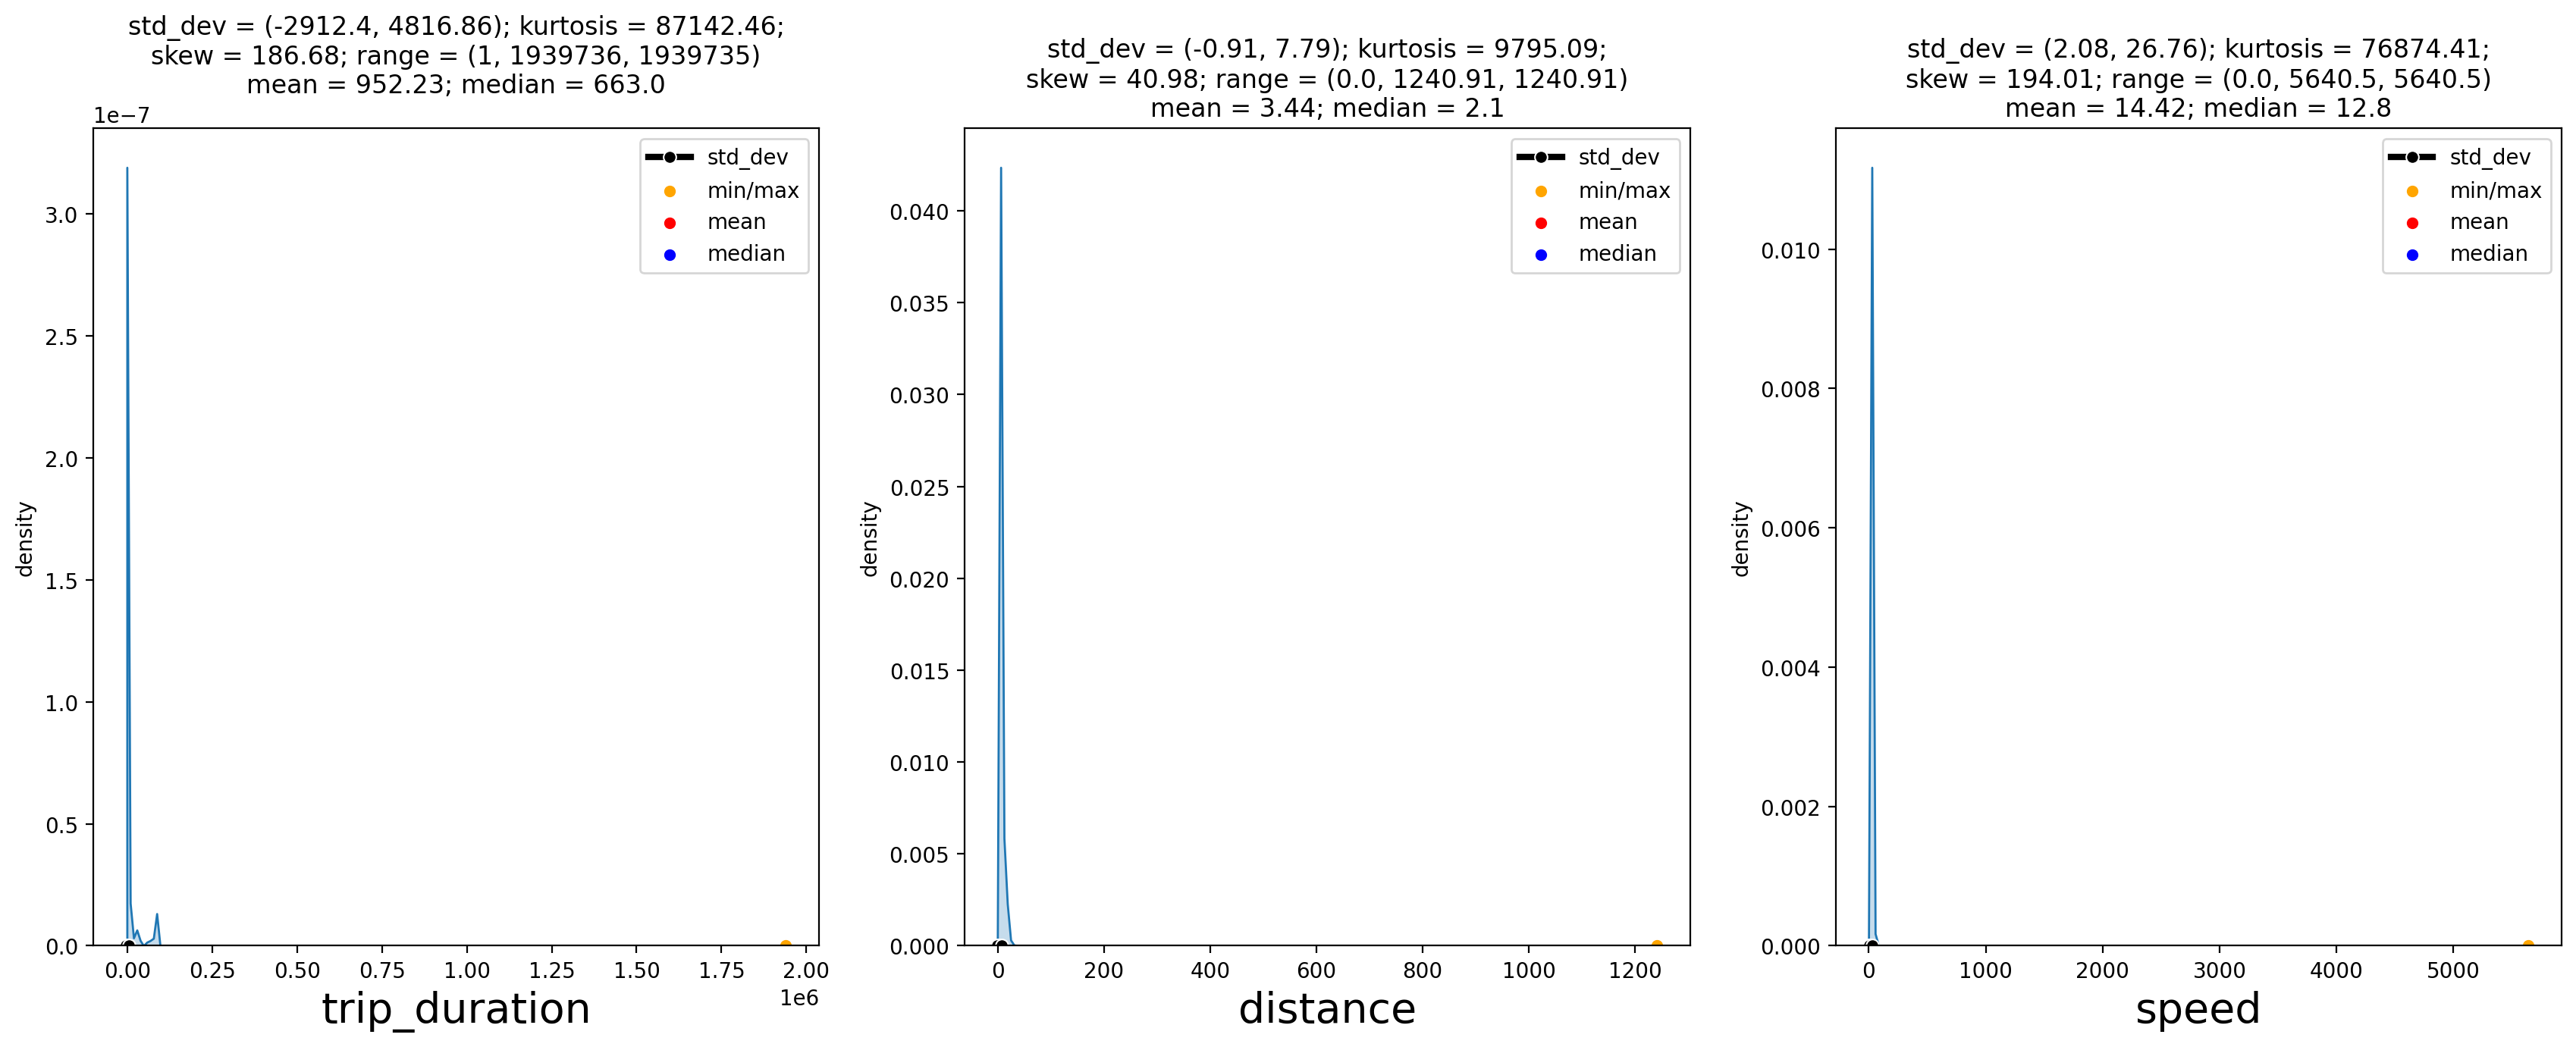

In [181]:
var_group = ['trip_duration', 'distance', 'speed' ]

UVA_numeric(nyc_df, var_group)

In [182]:
def UVA_numeric_remove_outliers(data, var_group):
    factor = 2
    # copying
    data = data[var_group]
    print(data['trip_duration'].std(),factor*data['trip_duration'].std())
    # filtering using standard deviation (not considering obseravtions > 3* standard deviation)
    data = data[data['trip_duration'] < factor*data['trip_duration'].std()]
    #data = data[data['trip_duration_hours'] < factor*data['trip_duration_hours'].std()]
    UVA_numeric(data, var_group)

3864.6261972811935 7729.252394562387


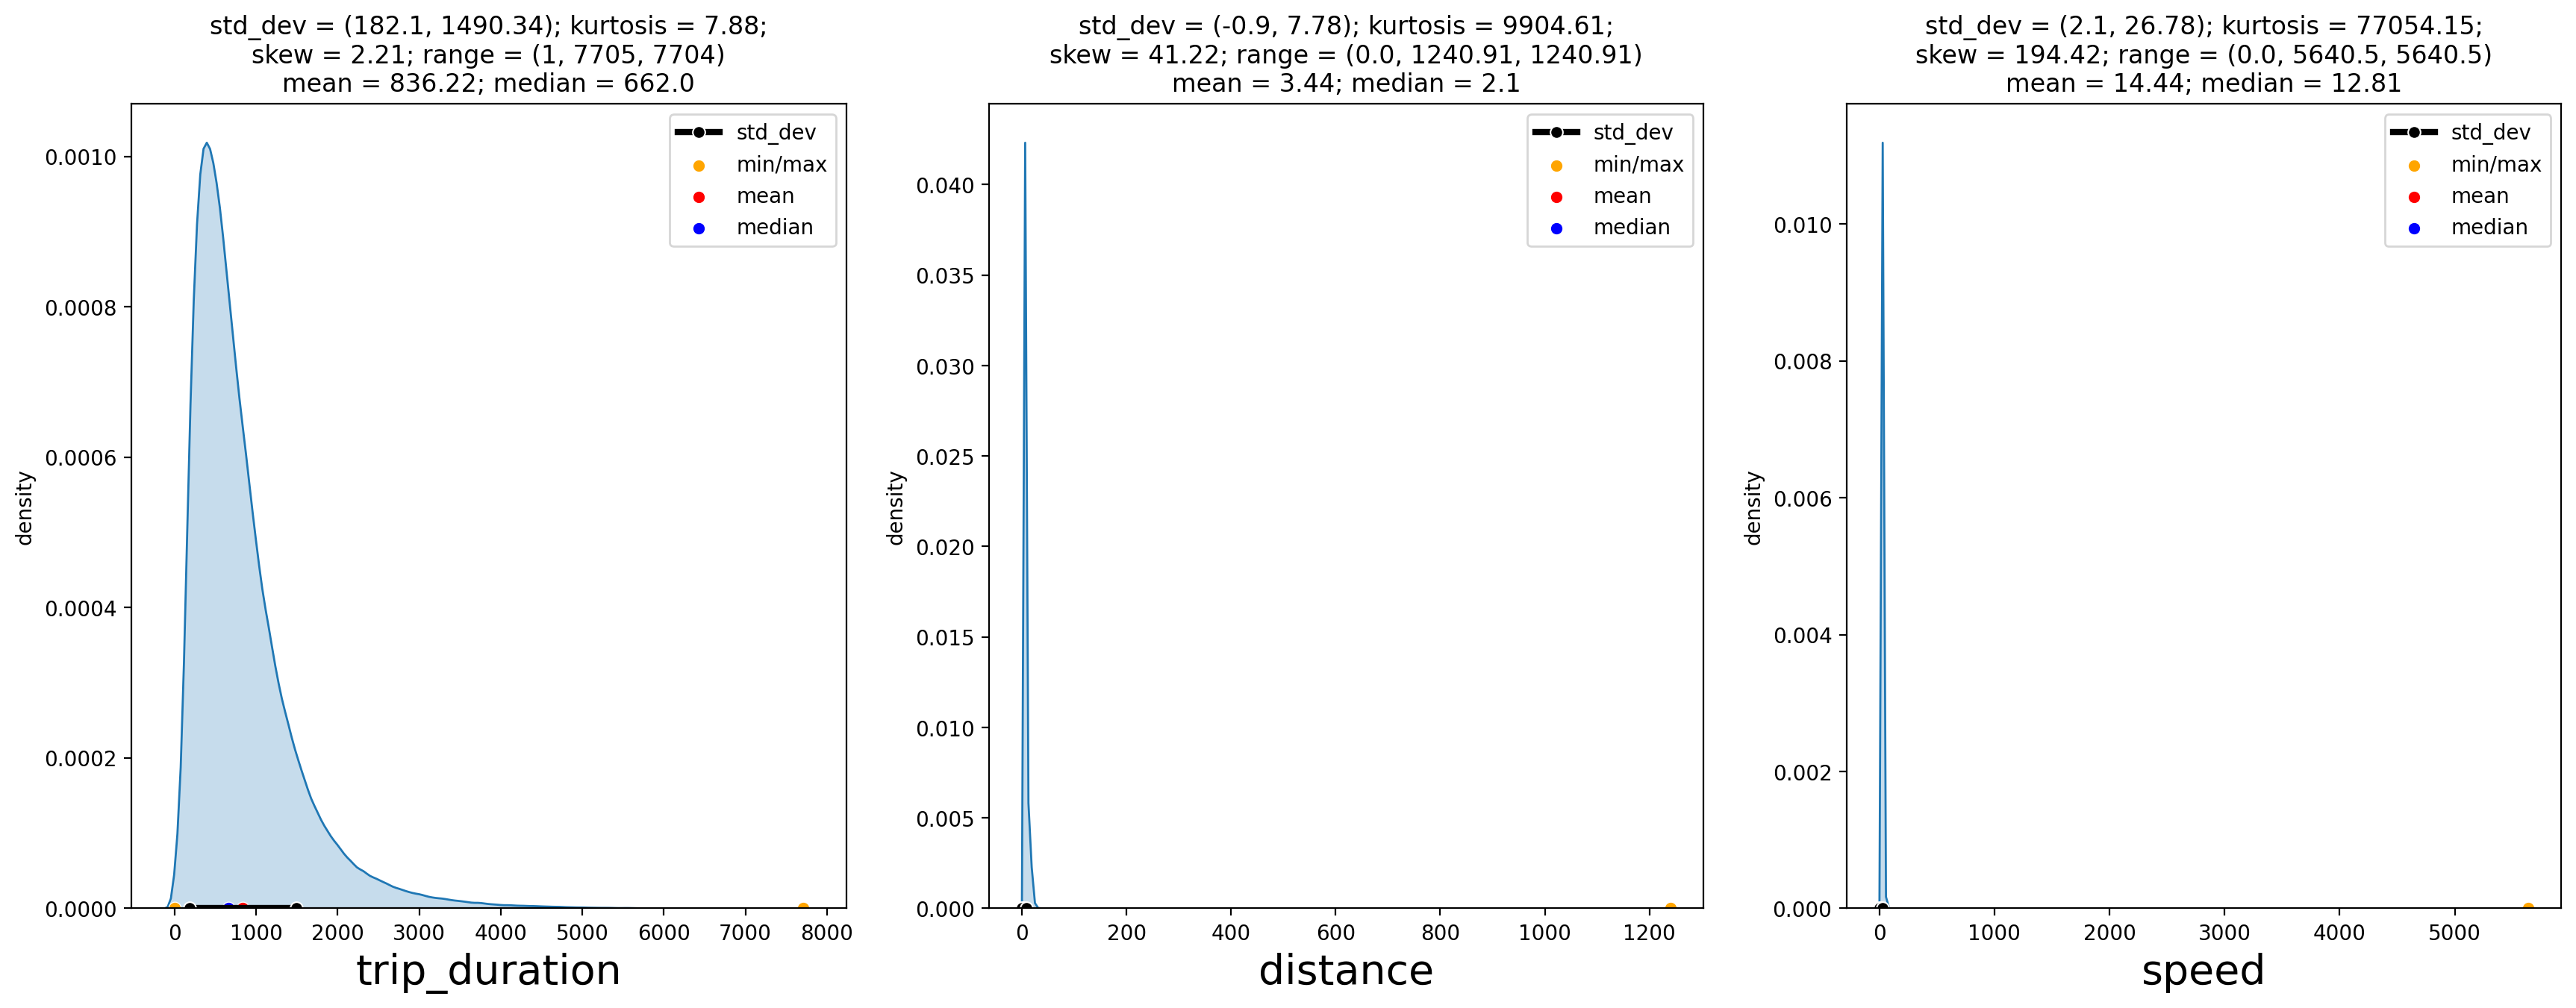

In [183]:
UVA_numeric_remove_outliers(nyc_df, var_group)

### Visualizing the distribution by histogram as range of distribution

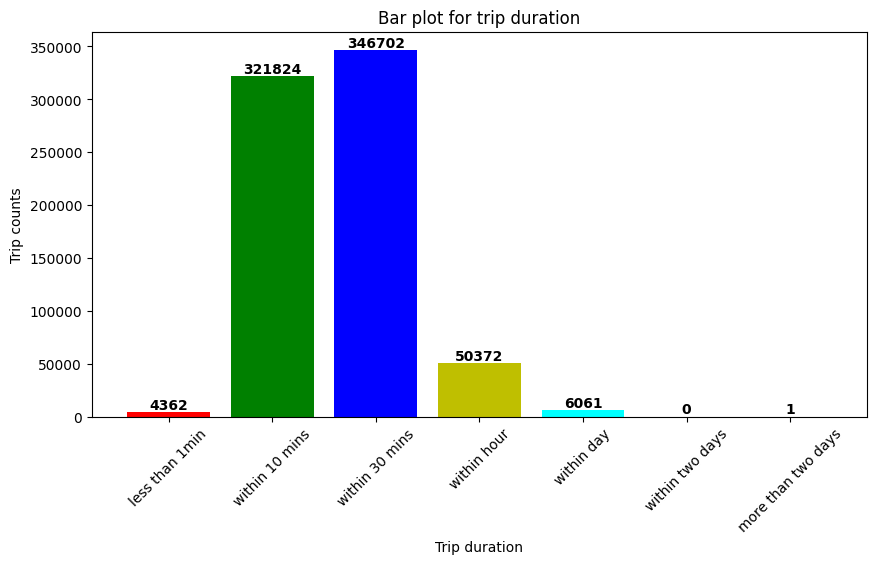

In [184]:
# Segregate the trip duration into different categories
# Segregate the trip duration into different categories
labels=['less than 1min','within 10 mins','within 30 mins','within hour','within day','within two days','more than two days']
counts1 = nyc_df.groupby(pd.cut(nyc_df['trip_duration'],bins=[0,60,600,1800,3600,86400,864002,10000000],labels=labels))['trip_duration'].count()

# Plot the bar charts in subplots
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.bar(counts1.index.astype(str), counts1.values, color=['r', 'g', 'b', 'y', 'cyan', 'orange', 'purple'])
axs.set_title('Bar plot for trip duration')
axs.set_xlabel('Trip duration')
axs.set_ylabel('Trip counts')
axs.tick_params(axis='x', rotation=45)
for i, val in enumerate(counts1.values):
    axs.text(i, val, int(val), ha='center', va='bottom', fontweight='bold', fontsize=10)

### Frequency distribution of Pickups/Dropoffs on days of week

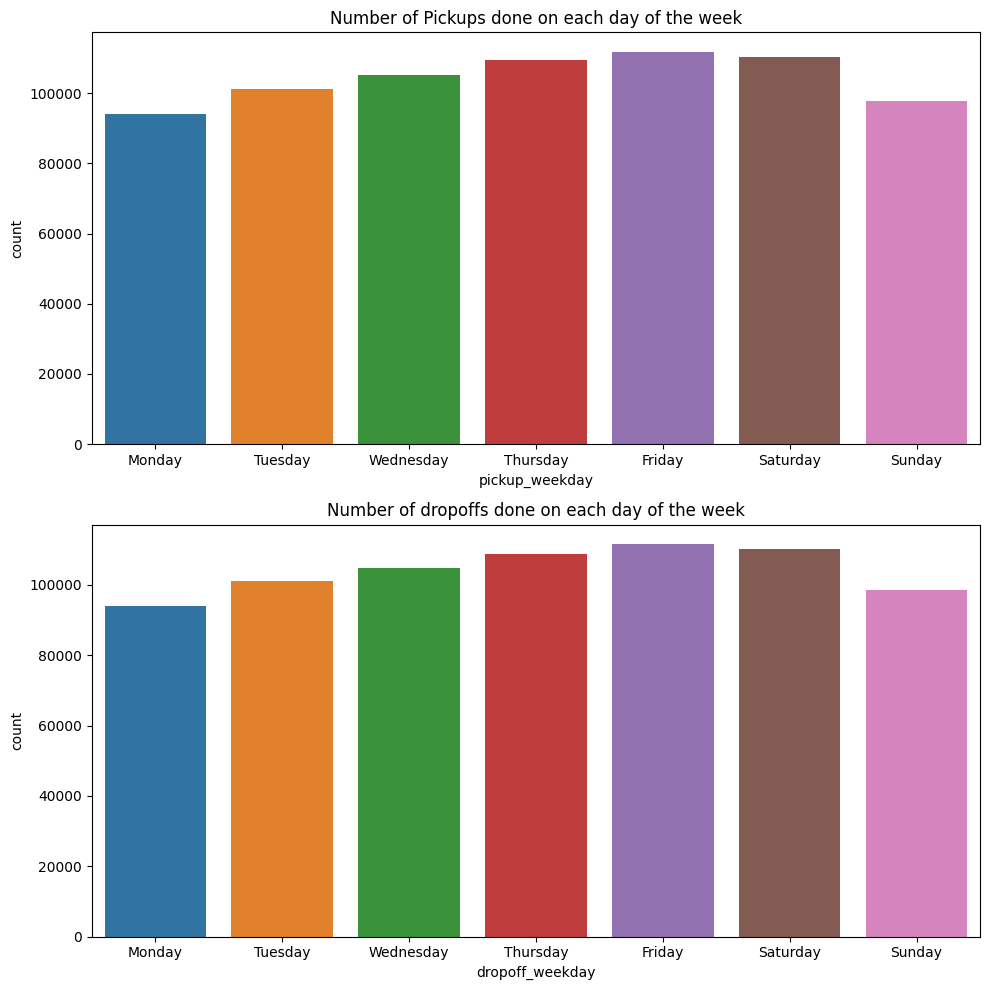

In [185]:
import calendar

#Number of Pickups and Dropoff on each day of the week
figure,ax=plt.subplots(nrows=2,ncols=1,figsize=(10,10))
sns.countplot(x='pickup_weekday',data=nyc_df,ax=ax[0], order= calendar.day_name)
ax[0].set_title('Number of Pickups done on each day of the week')
sns.countplot(x='dropoff_weekday',data=nyc_df,ax=ax[1], order= calendar.day_name)
ax[1].set_title('Number of dropoffs done on each day of the week')

plt.tight_layout()


- Here we can see an increasing trend of taxi pickups starting from Monday till Friday. The trend starts declining from saturday till monday which is normal where some office going people likes to stay at home for rest on the weekends. 

Let's drill down more to see the hourwise pickup pattern across the week

### Count of trips by hours on each day of weeks

<Figure size 1820x840 with 0 Axes>

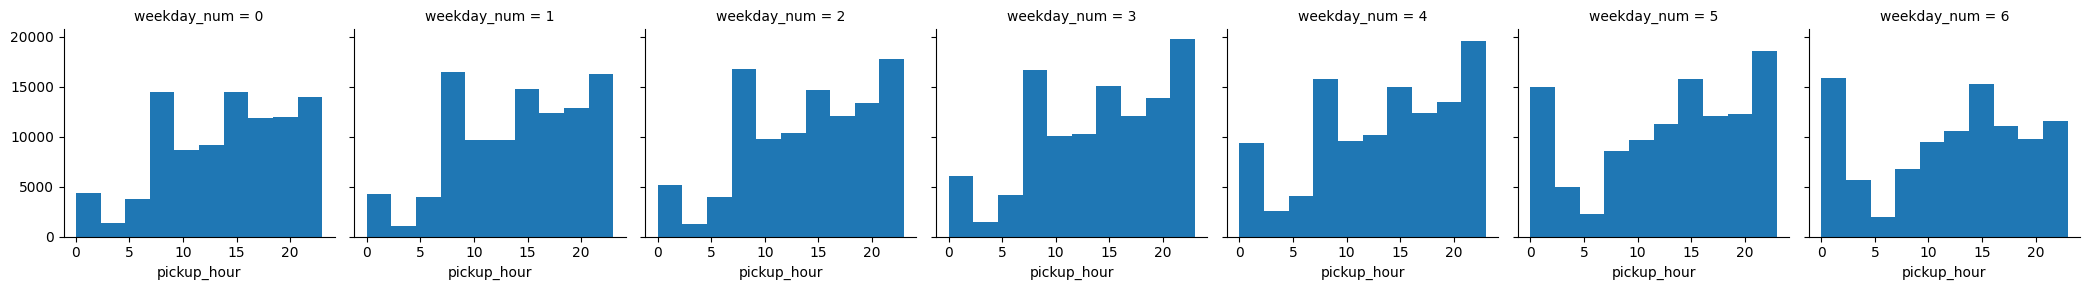

In [186]:
plt.figure(figsize = (13,6), dpi = 140)
n = sns.FacetGrid(nyc_df, col='weekday_num')
n.map(plt.hist, 'pickup_hour')
plt.show()


### Speed
***
Speed is a function of distance and time. Let's visualize speed in different trips.

Maximum speed limit in NYC is as follows:
- 40 kph in urban area 
- 104 kph on controlled state highways

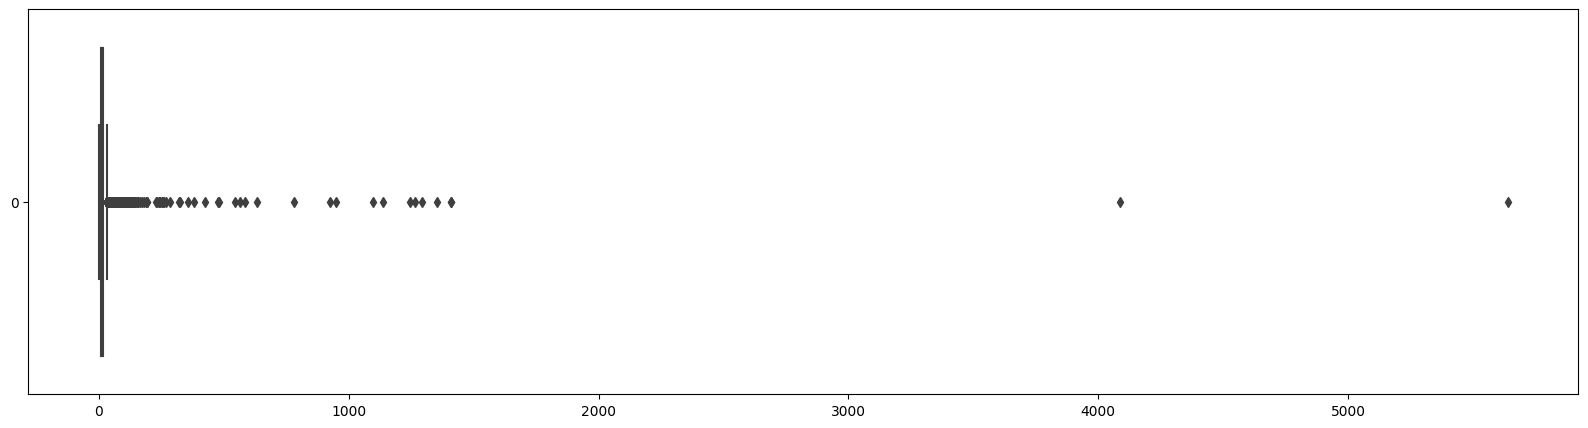

In [187]:
plt.figure(figsize = (20,5))
sns.boxplot(nyc_df.speed, orient='h')
plt.show()

re done at a speed of over 200 km/h. Going SuperSonic..!!

### Avg speed wrt trip count

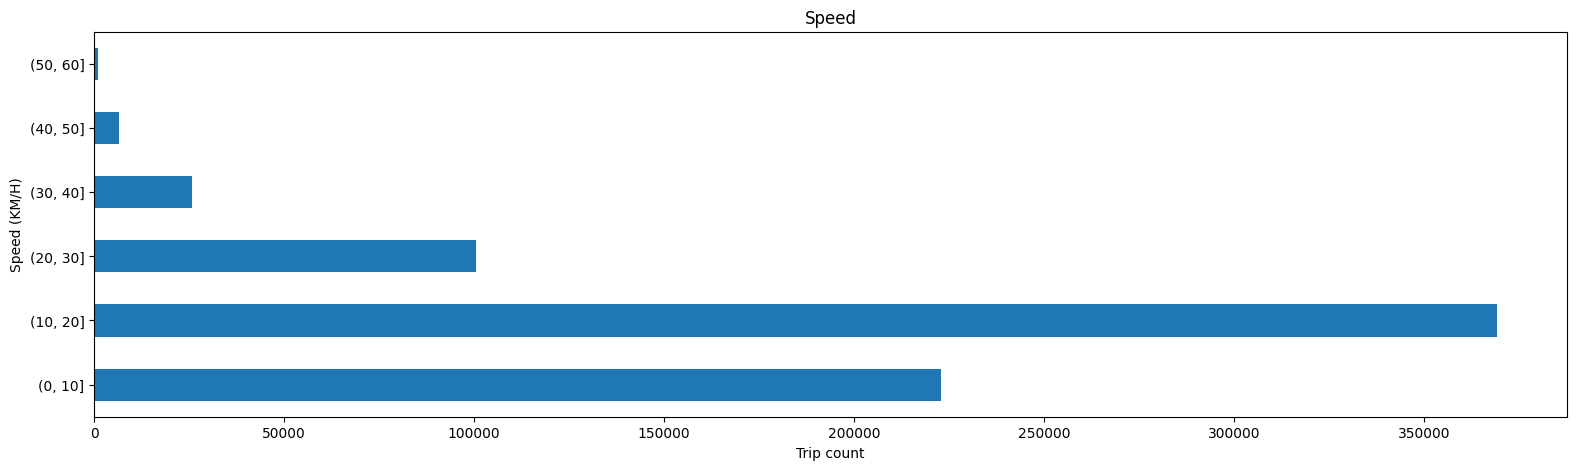

In [188]:
df = nyc_df[nyc_df.speed <= 65]
df.speed.groupby(pd.cut(df.speed, np.arange(0,65,10))).count().plot(kind = 'barh',figsize = (19,5))
plt.xlabel('Trip count')
plt.ylabel('Speed (KM/H)')
plt.title('Speed')
plt.show()

At the speed of 0 to 30 most of the trips are done, and at 10 to 20 maximum no. of trips are there.

<a id=month_trip></a>
### 9.Total trips per month
***
Let's take a look at the trip distribution across the months to understand if there is any diffrence in the taxi pickups in different months

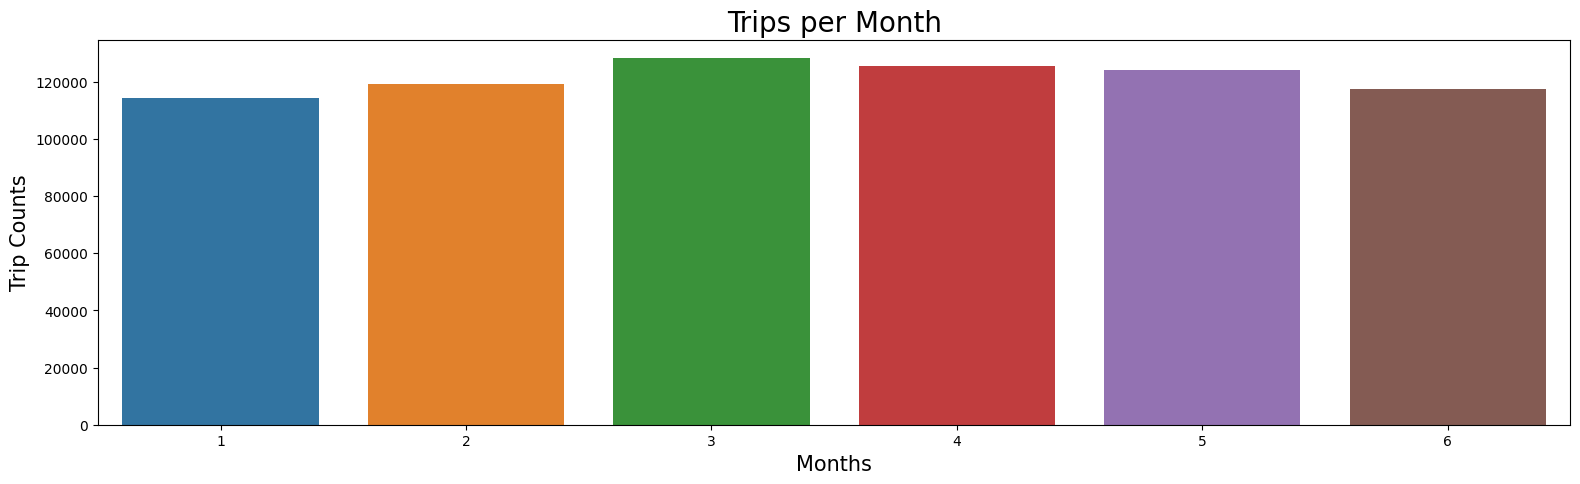

In [189]:
plt.figure(figsize = (19,5))
sns.countplot(nyc_df, x= 'month')
plt.ylabel('Trip Counts',fontsize = 15)
plt.xlabel('Months',fontsize = 15)
plt.title('Trips per Month',fontsize = 20)
plt.show()

## Bivariate Analysis

### Distance vs Trip Duration

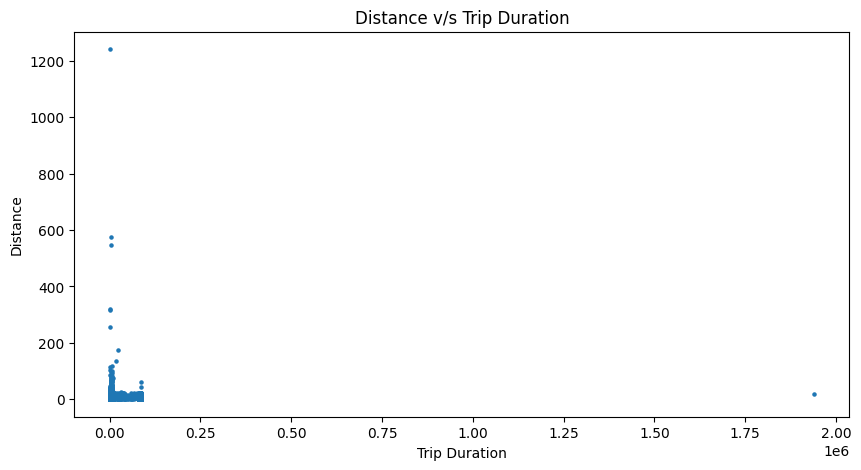

In [190]:
plt.figure(figsize = (10,5))
plt.scatter(nyc_df.trip_duration, nyc_df.distance , s=5, alpha=1)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.title('Distance v/s Trip Duration')
plt.show()

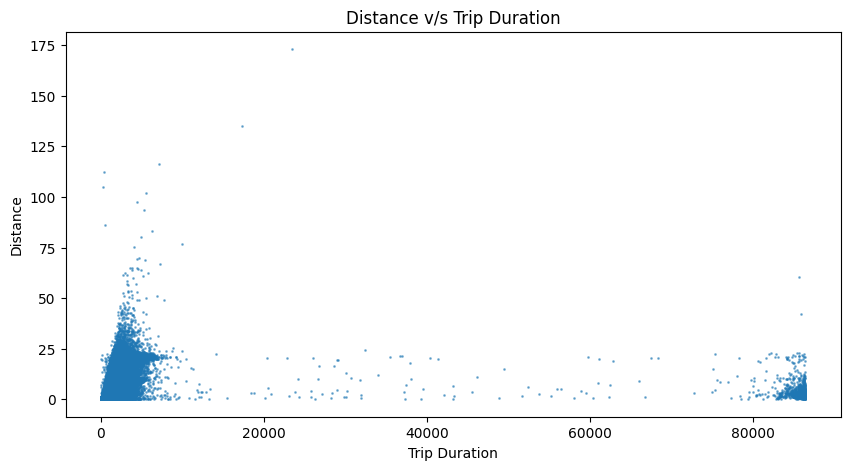

In [191]:
plt.figure(figsize = (10,5))
dur_dist = nyc_df.loc[(nyc_df.distance < 200) & (nyc_df.trip_duration < 1939736), ['distance','trip_duration']]
plt.scatter(dur_dist.trip_duration, dur_dist.distance , s=1, alpha=0.5)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.title('Distance v/s Trip Duration')
plt.show()

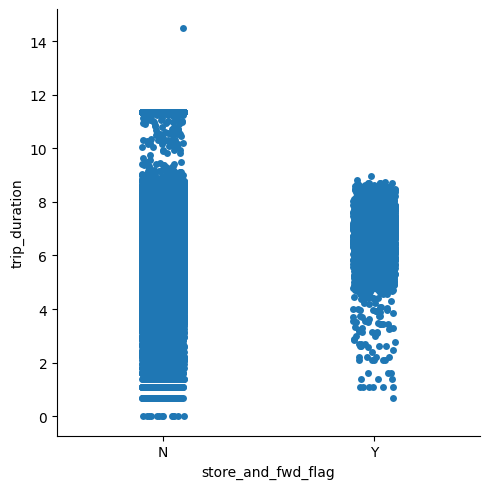

In [192]:
#Distribution of the Store and Fwd flag
sns.catplot(x="store_and_fwd_flag", y=np.log(nyc_df.trip_duration),kind="strip",data=nyc_df)

### Observations: 
- Above result shows that only about 1% of the trip details were stored in the vehicle first before sending it to the server. This might have occured because of the following reasons:
 1. Outstation trips didn't had proper connection at the time when trip completes.
 2. Temporary loss of signals while the trip was about to finish
 3. Inconsistent signal reception over the trip duration.
 4. The GPS or mobile device battery was down when the trip finished.


In [193]:
nyc_df[nyc_df['store_and_fwd_flag'] == 'N']['trip_duration'].sort_values()

398887          1
566349          1
312992          1
119181          1
512833          1
           ...   
496391      86377
177225      86378
119185      86387
259437      86391
21813     1939736
Name: trip_duration, Length: 725282, dtype: int64

In [194]:
nyc_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_weekday', 'dropoff_weekday', 'month',
       'weekday_num', 'pickup_hour', 'dropoff_hour', 'distance', 'speed',
       'duration_time', 'pickup_timezone', 'dropoff_timezone'],
      dtype='object')

## Correlation Check

In [195]:
feature = nyc_df[['vendor_id', 'passenger_count', 'month', 'weekday_num', 'pickup_hour',
       'distance', 'speed']].values
target = nyc_df['trip_duration'].values
x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.3,random_state = 42)

In [196]:
# create a dataframe with the feature and target variables
df = pd.DataFrame(x_train, columns=['vendor_id', 'passenger_count', 'month', 'weekday_num', 'pickup_hour', 'distance', 'speed'])
df['trip_duration'] = y_train

# calculate the correlation coefficients
pearson_corr = df.corr()['trip_duration']
spearman_corr = df.corr(method='spearman')['trip_duration']
kendall_corr = df.corr(method='kendall')['trip_duration']

# print the correlation coefficients
print("Pearson correlation coefficients:")
print(pearson_corr)

print("Spearman's rank correlation coefficients:")
print(spearman_corr)

print("Kendall's rank correlation coefficients:")
print(kendall_corr)

C:\Users\vikas\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:5278: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Pearson correlation coefficients:
vendor_id          0.035633
passenger_count    0.015864
month              0.012898
weekday_num       -0.001542
pickup_hour        0.005314
distance           0.147446
speed             -0.034331
trip_duration      1.000000
Name: trip_duration, dtype: float64
Spearman's rank correlation coefficients:
vendor_id          0.010544
passenger_count    0.025200
month              0.052458
weekday_num       -0.029856
pickup_hour        0.030260
distance           0.794234
speed             -0.043838
trip_duration      1.000000
Name: trip_duration, dtype: float64
Kendall's rank correlation coefficients:
vendor_id          0.008612
passenger_count    0.019604
month              0.037832
weekday_num       -0.021357
pickup_hour        0.020533
distance           0.606363
speed             -0.035123
trip_duration      1.000000
Name: trip_duration, dtype: float64


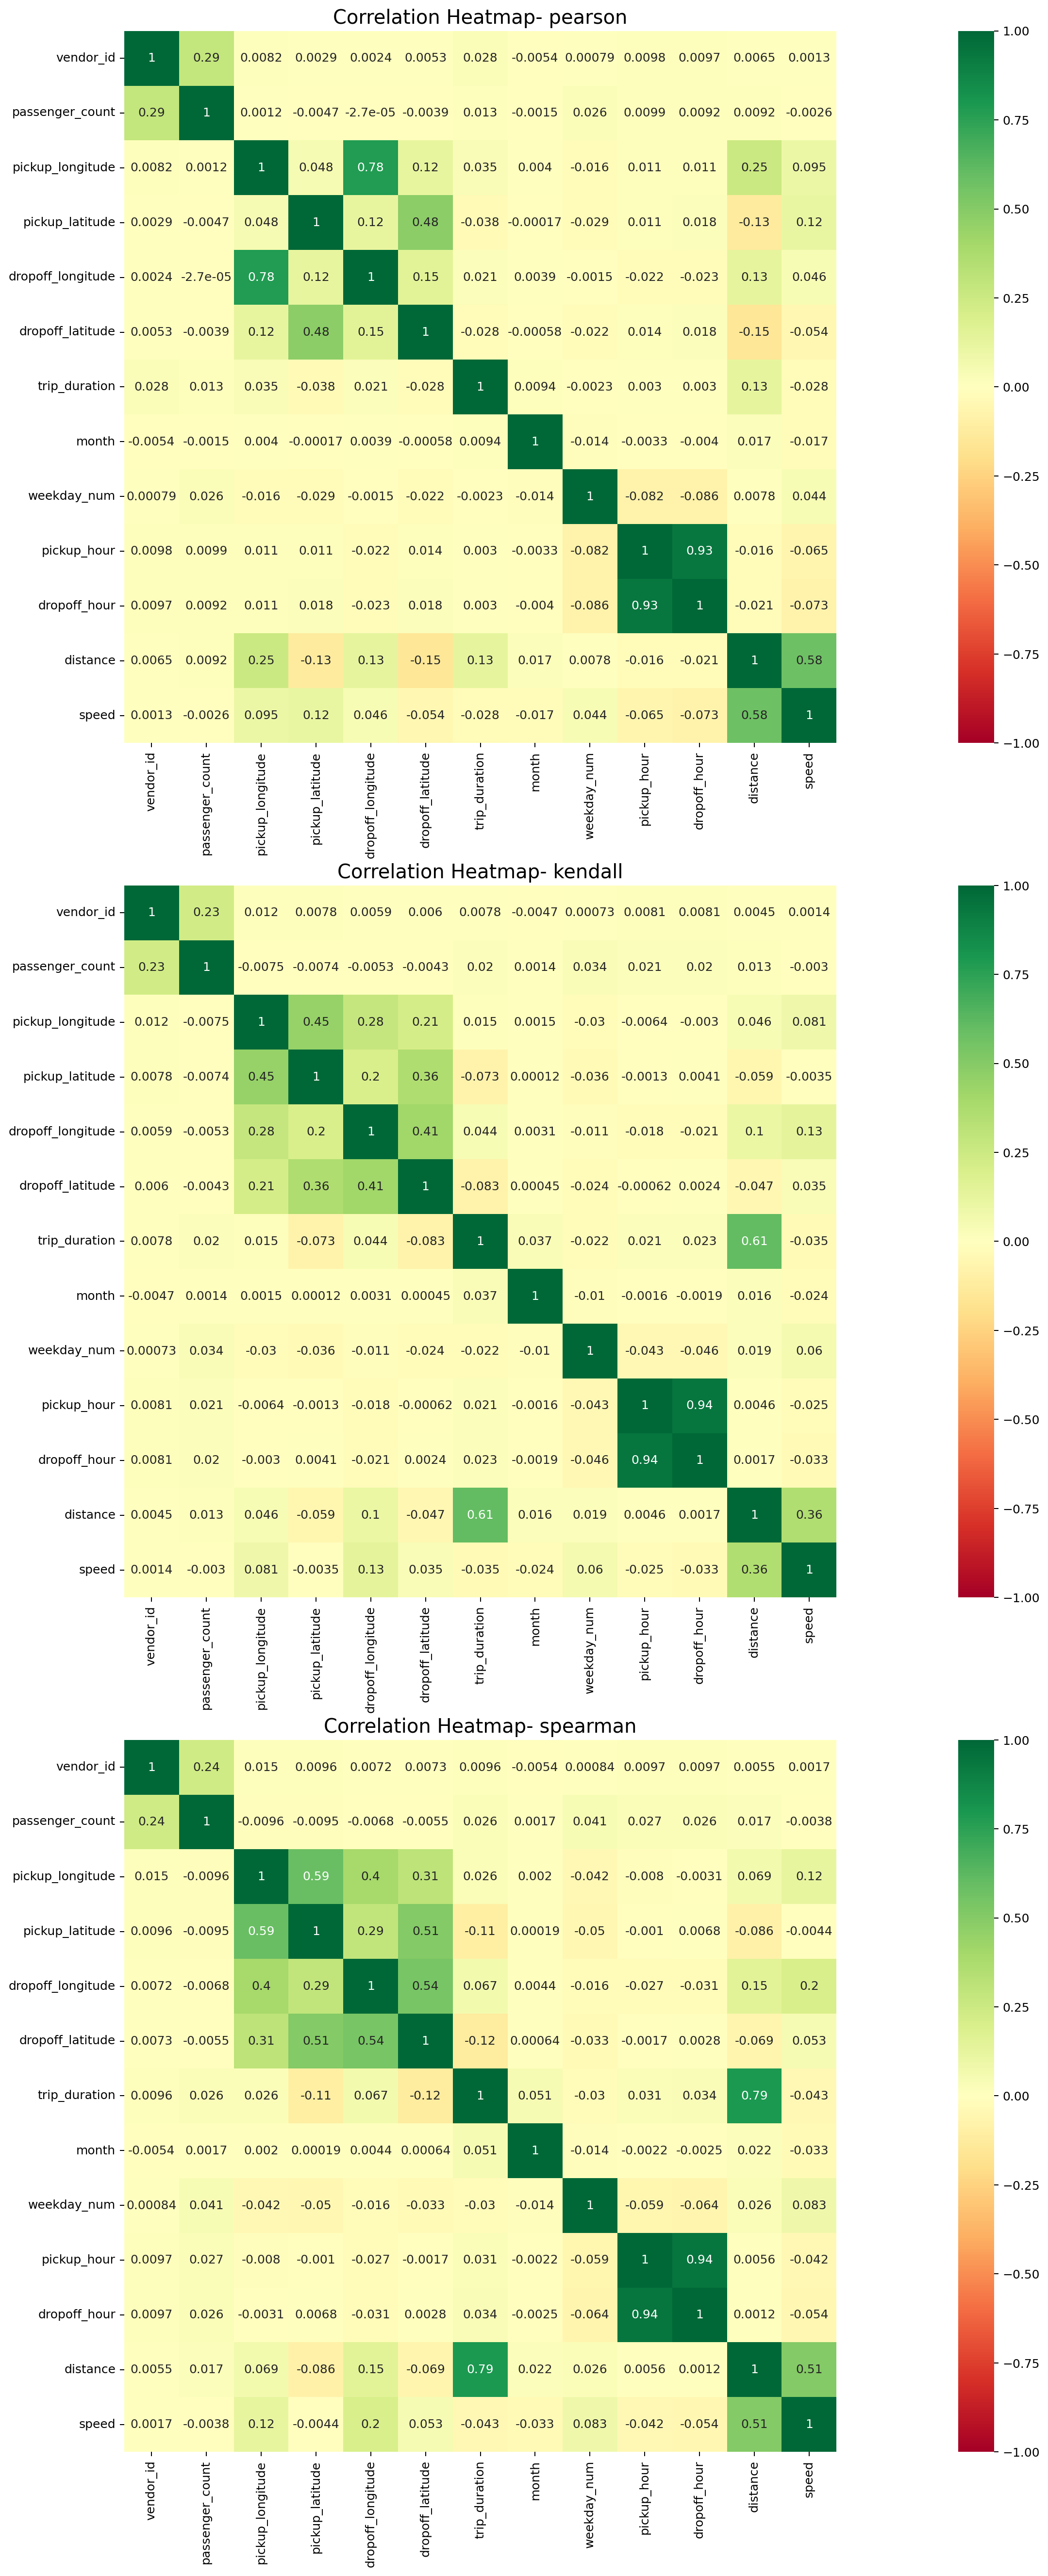

In [197]:
numeric = nyc_df.select_dtypes(include=[int,float])
plt.figure(figsize=(36,36), dpi=180)
for j,i in enumerate(['pearson','kendall','spearman']):
  plt.subplot(3,1,j+1)
  correlation = numeric.dropna().corr(method=i)
  sns.heatmap(correlation, cmap='RdYlGn', annot=True,vmin=-1, vmax=1, square=True)
  plt.title(f"Correlation Heatmap- {i}", fontsize=16)
plt.show()

Form the above we can infer that trip duration is highly dependent on distance feature. Also other aspects like month, weekday, hour, speed are also showing small amount of relation.

## Data Cleaning - Removing outliers for dataset for model.

In [198]:
#removing outlier
def exclude_outliers(data ,var_group ,outlier_coeff=1.5):

    # set number of rows and columns for subplots
    num_rows = len(var_group) // 3 + 1
    num_cols = 3

    # create the subplots
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5*num_rows))

    cleaned_data = data.copy()  # make a copy of the original data to remove outliers

    # loop through the numerical columns and create a boxplot on each subplot
    for idx, col in enumerate(var_group):
        row_idx = idx // num_cols
        col_idx = idx % num_cols

        # calculate the upper and lower bounds for the outliers
        q1 = cleaned_data[col].quantile(0.25)
        q3 = cleaned_data[col].quantile(0.75)
        iqr = q3 - q1
        upper_bound = q3 + outlier_coeff*iqr
        lower_bound = q1 - outlier_coeff*iqr

        # remove the outliers from the data
        data_no_outliers = cleaned_data[(cleaned_data[col] >= lower_bound) & (cleaned_data[col] <= upper_bound)]
        cleaned_data = data_no_outliers.copy()  # update cleaned_data for the next iteration

        # plot the boxplot without outliers
        axs[row_idx, col_idx].boxplot(data_no_outliers[col])
        axs[row_idx, col_idx].set_title(col)

    # remove any empty subplots
    for idx in range(len(var_group), num_rows*num_cols):
        row_idx = idx // num_cols
        col_idx = idx % num_cols
        fig.delaxes(axs[row_idx, col_idx])

    plt.tight_layout()
    plt.show()

    return cleaned_data

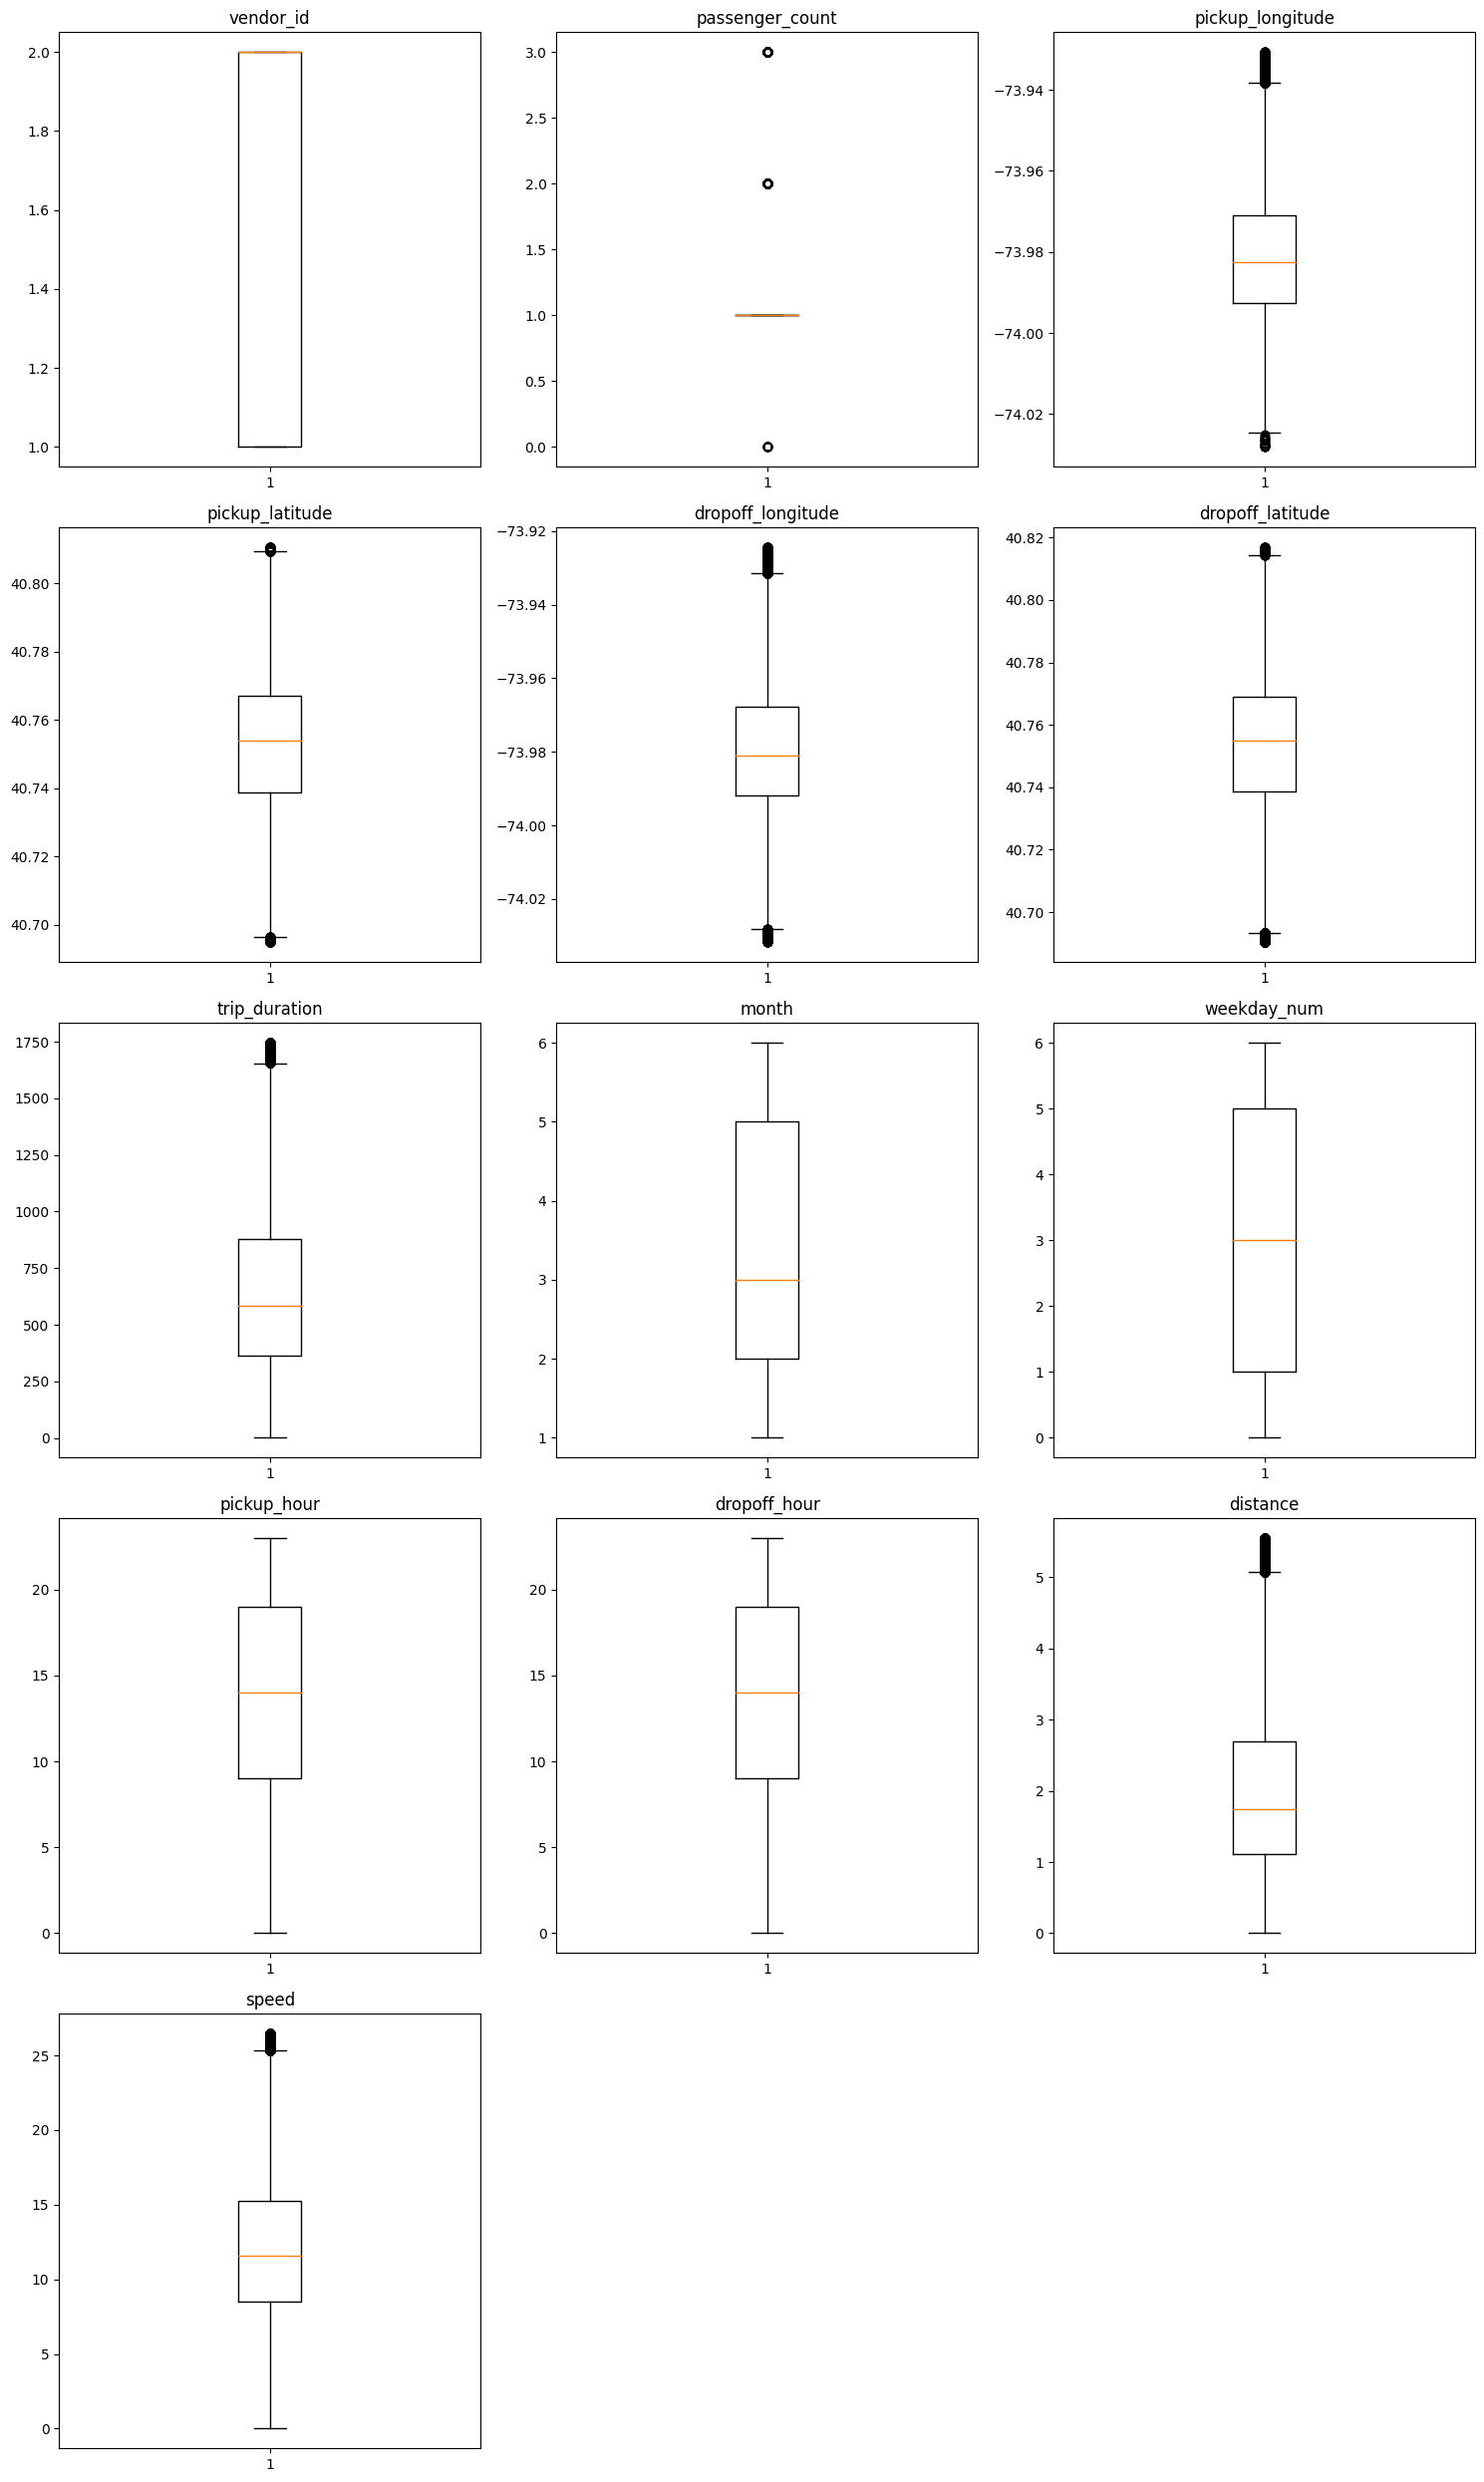

In [199]:
cleaned_df = exclude_outliers(nyc_df, numerical_col)

## Model implementation

### Brencnmark regression as Simple Linear Regression

From above correlation heatmap we can see that the distance and trip duration are highly correlated among others. So let try to apply basic benchmark model and seen if it can predicts the target trip duaration by knowing the distance between pickup and dropoff location.

In [200]:
train_mae_scores = []
train_rmse_scores = []
train_r2_scores = []
test_mae_scores = []
test_rmse_scores = []
test_r2_scores = []

### 1.Simple Linear Regression

In [227]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

def SimpleLinearRegress():
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(cleaned_df['distance'], cleaned_df['trip_duration'], test_size=0.3, random_state=42)

    # Define the input and output variables
    x_train = x_train.values.reshape(-1, 1)
    x_test = x_test.values.reshape(-1, 1)

    start_time = time.time()
    # Train the model
    simpleLR = LinearRegression()
    simpleLR.fit(x_train, y_train)
    end_time = time.time()
    lm_time = (end_time - start_time)
    print(f"Time taken to train simple linear regression model : {lm_time} seconds")
    # Evaluate the model
    train_pred = simpleLR.predict(x_train)
    train_rmse = mean_squared_error(y_train, train_pred, squared=False)
    train_mae = mean_absolute_error(y_train, train_pred)
    train_r2 = r2_score(y_train, train_pred)
    train_mae_scores.append(('Simple LR',train_mae))
    train_rmse_scores.append(('Simple LR',train_rmse))
    train_r2_scores.append(('Simple LR',train_r2))

    print('train_rmse:', train_rmse)
    print('train_mae:', train_mae)
    print('train_r2:', train_r2)

    test_pred = simpleLR.predict(x_test)
    test_rmse = mean_squared_error(y_test, test_pred, squared=False)
    test_mae = mean_absolute_error(y_test, test_pred)
    test_r2 = r2_score(y_test, test_pred)
    test_mae_scores.append(('Simple LR',test_mae))
    test_rmse_scores.append(('Simple LR',test_rmse))
    test_r2_scores.append(('Simple LR',test_r2))

    print('test_rmse:', test_rmse)
    print('test_mae:', test_mae)
    print('test_r2:', test_r2)

    # Make predictions
    new_data = pd.DataFrame({'distance': [10, 20, 30]})
    new_pred = simpleLR.predict(new_data)
    print("New Predictions:", new_pred)

In [228]:
SimpleLinearRegress()

Time taken to train simple linear regression model : 0.0 seconds
train_rmse: 256.3495242470103
train_mae: 196.57136992249076
train_r2: 0.4692296441461913
test_rmse: 254.83926112941438
test_mae: 195.58481122899238
test_r2: 0.47126745509427614
New Predictions: [2274.19747321 4320.34296561 6366.48845802]


C:\Users\vikas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


From above benchmark result we have r2 score of around 0.46 for train data and 0.47 for the test. Thus the prediction is not good in case of simple linear regression. Hence let's apply multiple linear regression and check the prediction and evaluation matrices after adding the features like timeline such as week_day, hour, day, speed etc, as we have seen that these things affects the trip duration as per the above EDA.


### 2.Multiple Linear Regression

In [202]:
feature = cleaned_df[['vendor_id', 'passenger_count', 'month', 'weekday_num', 'pickup_hour',
       'distance', 'speed']]
target = cleaned_df['trip_duration']



In [206]:
def LinearRegress(feature_var, target_var):

    start_time = time.time()
    x_train, x_test, y_train, y_test = train_test_split(feature_var, target_var, test_size=0.3,random_state = 42, stratify=target_var)
    lm_regression = LinearRegression()
    lm_regression = lm_regression.fit(x_train, y_train)
    end_time = time.time()
    lm_time = (end_time - start_time)
    print(f"Time taken to train linear regression model : {lm_time} seconds")


    # Evaluate the performance of the KNN model using MAE, RMSE, and R-squared

    train_pred = lm_regression.predict(x_train)
    train_rmse = mean_squared_error(y_train, train_pred, squared=False)
    train_mae = mean_absolute_error(y_train, train_pred)
    train_r2 = r2_score(y_train, train_pred)
    train_mae_scores.append(('Multiple_LR',train_mae))
    train_rmse_scores.append(('Multiple_LR',train_rmse))
    train_r2_scores.append(('Multiple_LR',train_r2))

    print('train_rmse:', train_rmse)
    print('train_mae:', train_mae)
    print('train_r2:', train_r2)

    test_pred = lm_regression.predict(x_test)
    test_rmse = mean_squared_error(y_test, test_pred, squared=False)
    test_mae = mean_absolute_error(y_test, test_pred)
    test_r2 = r2_score(y_test, test_pred)
    test_mae_scores.append(('Multiple_LR',test_mae))
    test_rmse_scores.append(('Multiple_LR',test_rmse))
    test_r2_scores.append(('Multiple_LR',test_r2))

    print('test_rmse:', test_rmse)
    print('test_mae:', test_mae)
    print('test_r2:', test_r2)

    predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
    return predictions, lm_regression, x_train

In [208]:
predictions, lm_regression, x_train = LinearRegress(feature, target)

Time taken to train linear regression model : 0.22982048988342285 seconds
train_rmse: 138.50122962814214
train_mae: 95.9779896762674
train_r2: 0.8447935867571439
test_rmse: 138.05594078241737
test_mae: 95.94098083522955
test_r2: 0.8454655894337111


Text(0.5, 1.0, 'Coefficient plot')

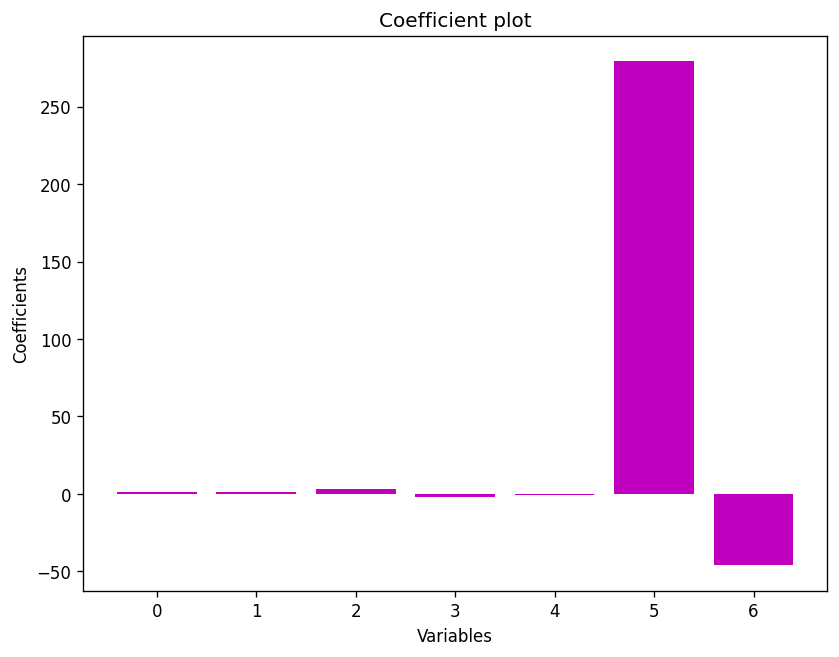

In [209]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='y')
x = range(len(x_train.columns))
y = lm_regression.coef_
plt.bar( x, y, color = 'm')
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Coefficient plot')


Here it is visible that the model is more dependent on distance and speed feature and less on time related features.

Lets scale the features and check again the coeficients.

Time taken to train linear regression model : 0.2482774257659912 seconds
train_rmse: 138.50122962814214
train_mae: 95.9779896762674
train_r2: 0.8447935867571439
test_rmse: 138.05594078241737
test_mae: 95.94098083522954
test_r2: 0.8454655894337111


Text(0.5, 1.0, 'Coefficient plot')

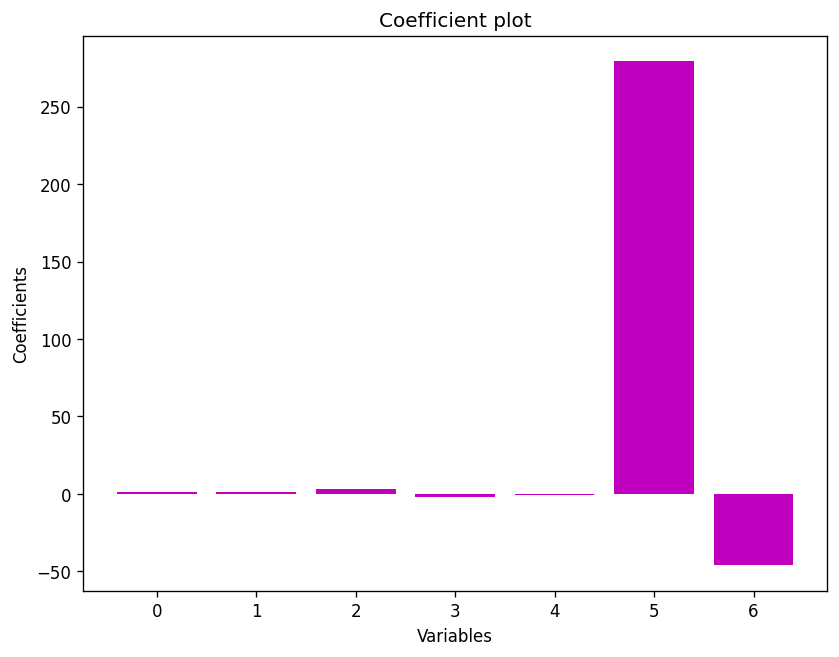

In [211]:
## Importing the MinMax Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(feature)
x_scaled = pd.DataFrame(x_scaled, columns=feature.columns)
predictions,_,_ = LinearRegress(x_scaled, target)


plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='y')
x = range(len(x_scaled.columns))
y = lm_regression.coef_
plt.bar( x, y, color = 'm')
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Coefficient plot')

From above we infer that there is no change in prediction and score if we study deeply we find that
Scaled features perform well in KNN because KNN is a distance-based algorithm, where the distance between two data points plays a crucial role in determining their similarity. When features are on different scales, the distance between data points can be dominated by the features with larger scales, leading to inaccurate results.

On the other hand, in linear regression, the scale of features does not affect the quality of the predictions since the coefficients of the features will adjust accordingly to the scale of the features during the model training. Therefore, scaling features in linear regression may not necessarily lead to improved results.

### Checking assumptions of Linear Model and plotting residual distribution

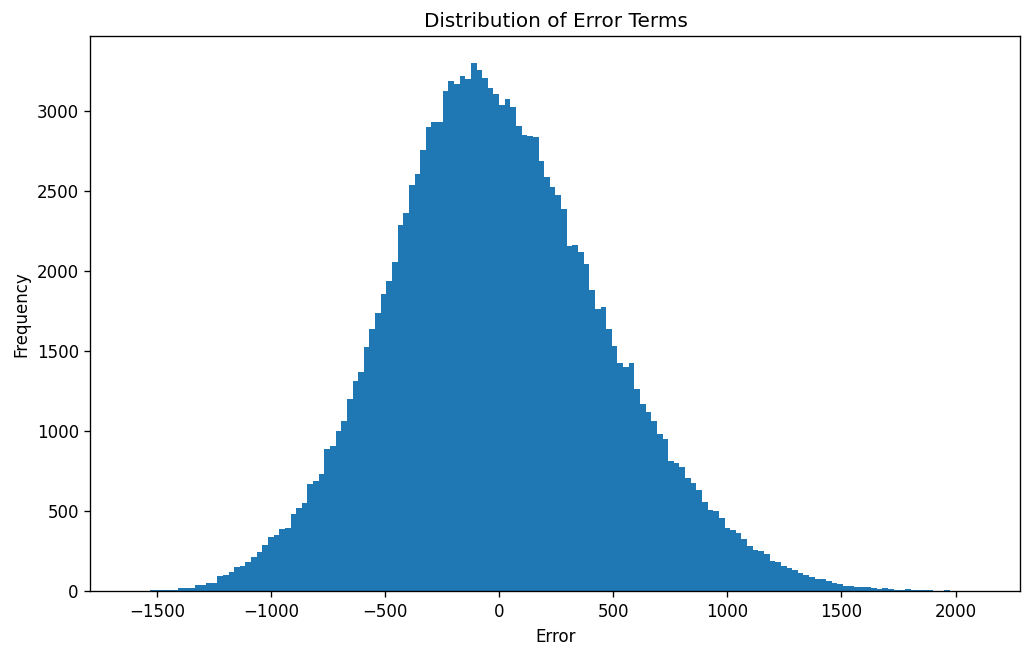

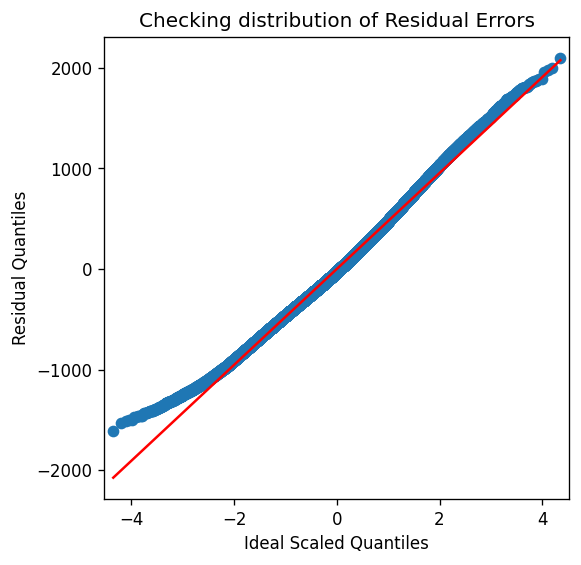

In [216]:
# importing the QQ-plot from the from the statsmodels
from statsmodels.graphics.gofplots import qqplot

# calculating the Residuals

predictions['residuals'] = predictions['Actual'] - predictions['Predicted']

# Histogram for distribution
plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
plt.hist(predictions.residuals, bins = 150)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of Error Terms')
plt.show()


## Plotting the QQ plot
fig, ax = plt.subplots(figsize=(5,5) , dpi = 120)
qqplot(predictions.residuals, line = 's' , ax = ax)
plt.ylabel('Residual Quantiles')
plt.xlabel('Ideal Scaled Quantiles')
plt.title('Checking distribution of Residual Errors')
plt.show()

predictions = predictions.drop('residuals', axis=1)

Here we can see that the distribution of error is normally distributed.

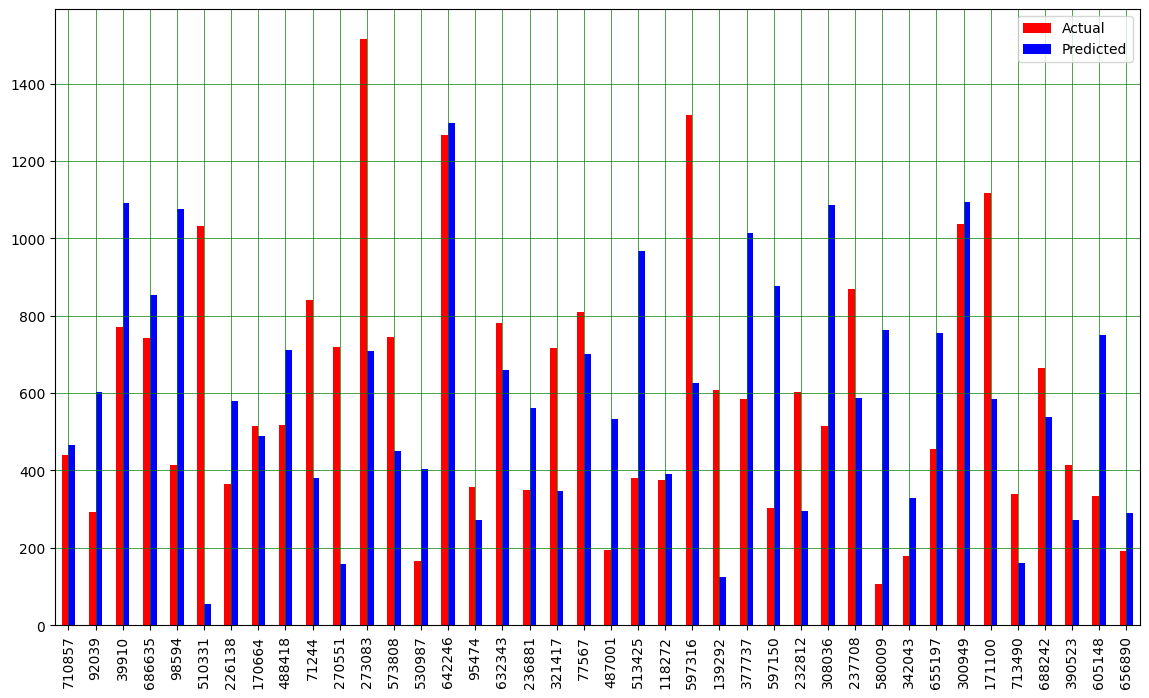

In [217]:
predictions.sample(40).plot(kind='bar',figsize=(14,8), color=['red', 'blue'] )
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='blue')
plt.show()

### 3.K-Nearest Neighbors 

In [218]:
def KNNRegressor(feature_var, target_var, k=5):

    from sklearn.neighbors import KNeighborsRegressor

    import time
    start_time = time.time()
    # Initialize the KNN regressor model
    x_train, x_test, y_train, y_test = train_test_split(feature_var, target_var, test_size=0.3,random_state = 42, stratify=target_var)
    knn = KNeighborsRegressor(n_neighbors=k)

    # Train the KNN model on the training set
    knn.fit(x_train, y_train)
    end_time = time.time()
    lm_time = (end_time - start_time)
    print(f"Time taken to train KNN model : {lm_time} seconds")
    # Use the trained model to make predictions on the test set
    y_pred = knn.predict(x_test)

    # Evaluate the performance of the KNN model using MAE, RMSE, and R-squared
    train_pred = knn.predict(x_train)
    train_rmse = mean_squared_error(y_train, train_pred, squared=False)
    train_mae = mean_absolute_error(y_train, train_pred)
    train_r2 = r2_score(y_train, train_pred)
    train_mae_scores.append(('knn',train_mae))
    train_rmse_scores.append(('knn',train_rmse))
    train_r2_scores.append(('knn',train_r2))

    print('train_rmse:', train_rmse)
    print('train_mae:', train_mae)
    print('train_r2:', train_r2)

    test_pred = knn.predict(x_test)
    test_rmse = mean_squared_error(y_test, test_pred, squared=False)
    test_mae = mean_absolute_error(y_test, test_pred)
    test_r2 = r2_score(y_test, test_pred)
    test_mae_scores.append(('knn',test_mae))
    test_rmse_scores.append(('knn',test_rmse))
    test_r2_scores.append(('knn',test_r2))

    print('test_rmse:', test_rmse)
    print('test_mae:', test_mae)
    print('test_r2:', test_r2)

    predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
    return predictions,test_rmse, train_rmse

In [219]:
KNNRegressor(feature, target)

Time taken to train KNN model : 0.7407283782958984 seconds
train_rmse: 80.97735394870386
train_mae: 50.86207947311402
train_r2: 0.9469446031536782
test_rmse: 99.52262869454374
test_mae: 62.88049330345232
test_r2: 0.9196920245747595


(        Actual  Predicted
 400606     274      256.6
 654884     745      699.6
 216207    1332     1312.4
 351570     257      473.6
 404483     330      378.0
 ...        ...        ...
 302403     509      503.8
 51694      336      403.2
 704242     489      795.6
 645668     765      786.0
 439448    1008      956.0
 
 [149928 rows x 2 columns],
 99.52262869454374,
 80.97735394870386)

### K Elbow

finding the best k value by reducing the error.

Time taken to train KNN model : 0.7560656070709229 seconds
train_rmse: 13.657953338297158
train_mae: 0.2708437550917734
train_r2: 0.9984907066668571
test_rmse: 124.98661002932639
test_mae: 78.81304359425857
test_r2: 0.8733392724440955
Time taken to train KNN model : 0.7469978332519531 seconds
train_rmse: 62.25017695797802
train_mae: 39.22849163448428
train_r2: 0.9686466763853497
test_rmse: 108.71788781666228
test_mae: 68.22468118029988
test_r2: 0.9041665742921625
Time taken to train KNN model : 0.7501826286315918 seconds
train_rmse: 72.70438844715382
train_mae: 45.45410662542747
train_r2: 0.9572315357334875
test_rmse: 103.06582321926508
test_mae: 65.01835770058517
test_r2: 0.9138720018244499
Time taken to train KNN model : 0.7742962837219238 seconds
train_rmse: 77.77866240011795
train_mae: 48.77833098456674
train_r2: 0.9510533081476474
test_rmse: 100.84313705311273
test_mae: 63.53768142041513
test_r2: 0.9175467658574438
Time taken to train KNN model : 0.7591588497161865 seconds
train_r

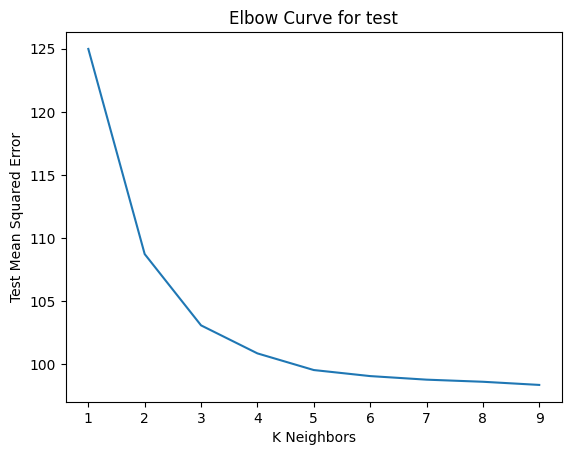

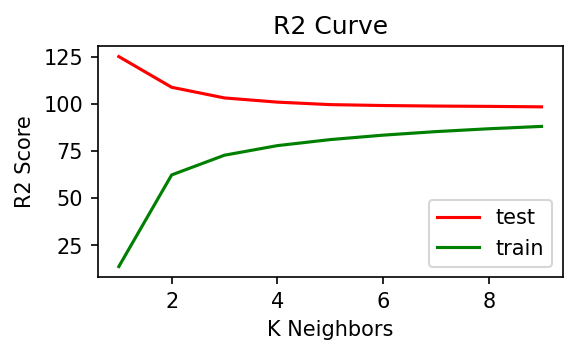

In [220]:
k = range(1,10)

def Elbow(k):
  #initiating empty list
    list_train_rmse = []
    list_test_rmse = []
  
  #training model for evey value of K
    for i in k:
        #Instance of KNN
        _, test_1, train_1 = KNNRegressor(feature,target, k = i)
        list_test_rmse.append(test_1)
        list_train_rmse.append(train_1)
    return list_test_rmse,list_train_rmse

test, train = Elbow(k)
plt.plot(k, test)
plt.xlabel('K Neighbors')
plt.ylabel('Test Mean Squared Error')
plt.title('Elbow Curve for test')
plt.xticks(k)

# plotting the Curvesg
plt.figure(figsize=(4,2), dpi=150)
plt.plot(k, test, color = 'red' , label = 'test')
plt.plot(k, train, color = 'green', label = 'train')
plt.xlabel('K Neighbors')
plt.ylabel('R2 Score')
plt.title('R2 Curve')
plt.legend()

### Observation

FRom above we can infer that the error reduced after the k=7 and from test and train curve the error is approx. moving contant. Thus we can plot conclude that using elbow method k=7 will give the best fit for the model.

In [221]:
## Importing the MinMax Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(feature)
x_scaled = pd.DataFrame(x_scaled, columns=feature.columns)
predictions,_,_ = KNNRegressor(x_scaled, target, k=7)


Time taken to train KNN model : 0.6660196781158447 seconds
train_rmse: 65.22465189375438
train_mae: 32.69198175598444
train_r2: 0.965578804950647
test_rmse: 77.14410313299119
test_mae: 38.29299015908589
test_r2: 0.9517474278182116


### Oberservation

From above we saw that after scaling using minmaxscaler the performance of KNN improved as r2 value is more closer to 1 then before and time taken in training the model is reduced.

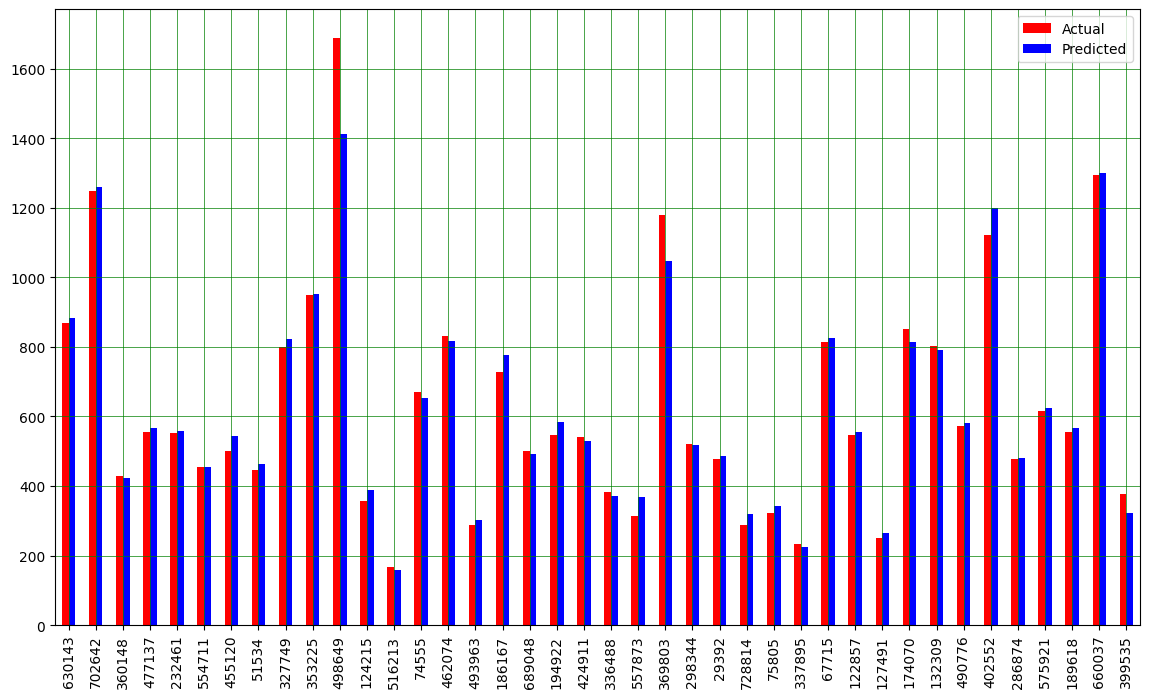

In [222]:
predictions.sample(40).plot(kind='bar',figsize=(14,8),color=['red', 'blue'])
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### 4.Decision Tree

In [223]:
def DecisionTree(feature_var, target_var):

    start_time = time.time()
    dt_regression = DecisionTreeRegressor()
    x_train, x_test, y_train, y_test = train_test_split(feature_var, target_var, test_size=0.3,random_state = 42, stratify=target_var)
    dt_regression = dt_regression.fit(x_train, y_train)
    end_time = time.time()
    dt_time = (end_time - start_time)

    trips = dt_regression.predict(x_test)

    print(f"Time taken to train Decision tree model : {dt_time} seconds")

    # Evaluate the performance of the KNN model using MAE, RMSE, and R-squared
    train_pred = dt_regression.predict(x_train)
    train_rmse = mean_squared_error(y_train, train_pred, squared=False)
    train_mae = mean_absolute_error(y_train, train_pred)
    train_r2 = r2_score(y_train, train_pred)
    train_mae_scores.append(('DT',train_mae))
    train_rmse_scores.append(('DT',train_rmse))
    train_r2_scores.append(('DT',train_r2))

    print('train_rmse:', train_rmse)
    print('train_mae:', train_mae)
    print('train_r2:', train_r2)

    test_pred = dt_regression.predict(x_test)
    test_rmse = mean_squared_error(y_test, test_pred, squared=False)
    test_mae = mean_absolute_error(y_test, test_pred)
    test_r2 = r2_score(y_test, test_pred)
    test_mae_scores.append(('DT',test_mae))
    test_rmse_scores.append(('DT',test_rmse))
    test_r2_scores.append(('DT',test_r2))

    print('test_rmse:', test_rmse)
    print('test_mae:', test_mae)
    print('test_r2:', test_r2)

    predictions = pd.DataFrame({'Actual': y_test, 'Predicted': trips.flatten()})

    predictions

In [224]:
DecisionTree(feature, target)

Time taken to train Decision tree model : 1.9105956554412842 seconds
train_rmse: 9.93964708570052
train_mae: 0.2679690172436628
train_r2: 0.9992006364632675
test_rmse: 31.705608681015185
test_mae: 3.6602385811856357
test_r2: 0.991849444845047


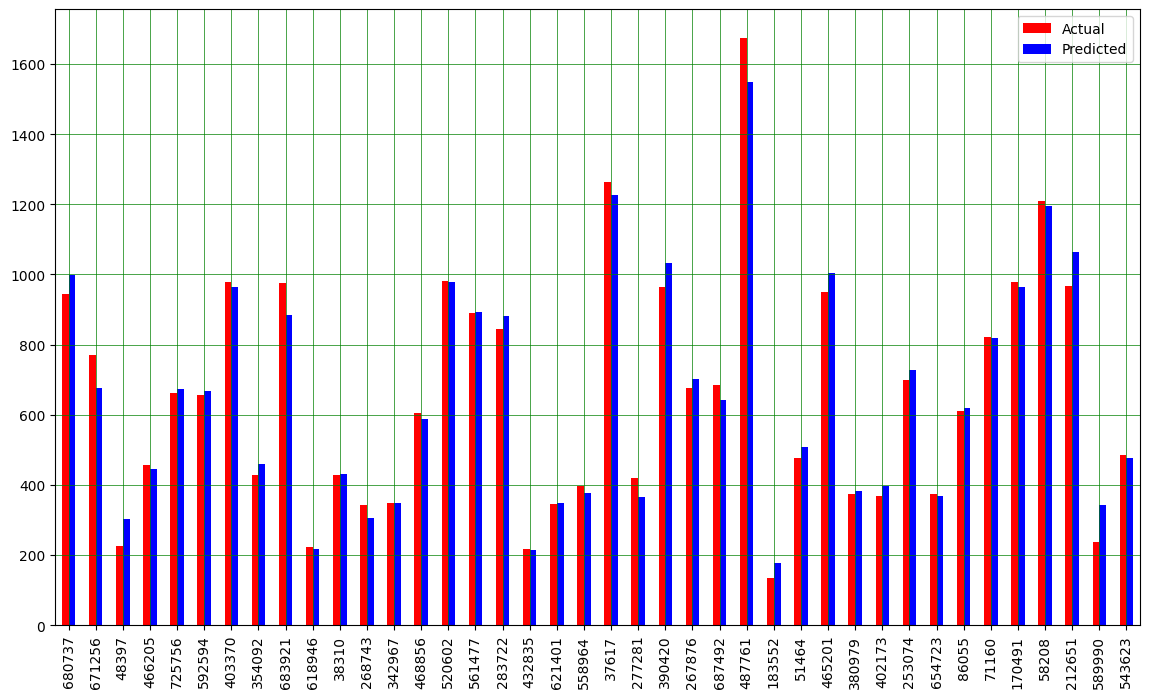

In [226]:
predictions.sample(40).plot(kind='bar',figsize=(14,8),color=['red', 'blue'] )
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Summarizing

lets getther the test scores of all the models and see which model performs well.

In [241]:
# flushing the score list
train_mae_scores.clear()
train_rmse_scores.clear()
train_r2_scores.clear()
test_mae_scores.clear()
test_rmse_scores.clear()
test_r2_scores.clear()

In [242]:
# rerunning the all the models and storing the score values.
SimpleLinearRegress()
LinearRegress(feature, target)
KNNRegressor(x_scaled, target, k=7)
DecisionTree(feature, target)



Time taken to train simple linear regression model : 0.023383378982543945 seconds
train_rmse: 256.3495242470103
train_mae: 196.57136992249076
train_r2: 0.4692296441461913
test_rmse: 254.83926112941438
test_mae: 195.58481122899238
test_r2: 0.47126745509427614
New Predictions: [2274.19747321 4320.34296561 6366.48845802]


C:\Users\vikas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Time taken to train linear regression model : 0.24774861335754395 seconds
train_rmse: 138.50122962814214
train_mae: 95.9779896762674
train_r2: 0.8447935867571439
test_rmse: 138.05594078241737
test_mae: 95.94098083522955
test_r2: 0.8454655894337111
Time taken to train KNN model : 0.6710355281829834 seconds
train_rmse: 65.22465189375438
train_mae: 32.69198175598444
train_r2: 0.965578804950647
test_rmse: 77.14410313299119
test_mae: 38.29299015908589
test_r2: 0.9517474278182116
Time taken to train Decision tree model : 1.9382424354553223 seconds
train_rmse: 9.93964708570052
train_mae: 0.2679690172436628
train_r2: 0.9992006364632675
test_rmse: 31.9612111511615
test_mae: 3.6672441660886115
test_r2: 0.9917174997640024


In [245]:
score_df = pd.DataFrame({'Model': [x[0] for x in train_mae_scores],
                   'Train MAE': [x[1] for x in train_mae_scores],
                   'Train RMSE': [x[1] for x in train_rmse_scores],
                   'Train R2': [x[1] for x in train_r2_scores],
                   'Test MAE': [x[1] for x in test_mae_scores],
                   'Test RMSE': [x[1] for x in test_rmse_scores],
                   'Test R2': [x[1] for x in test_r2_scores]})

score_df.set_index('Model', inplace=True)

In [246]:
score_df

,Train MAE,Train RMSE,Train R2,Test MAE,Test RMSE,Test R2
Model,,,,,,
Simple LR,196.571370,256.349524,0.469230,195.584811,254.839261,0.471267
Multiple_LR,95.977990,138.501230,0.844794,95.940981,138.055941,0.845466
knn,32.691982,65.224652,0.965579,38.292990,77.144103,0.951747
DT,0.267969,9.939647,0.999201,3.667244,31.961211,0.991717


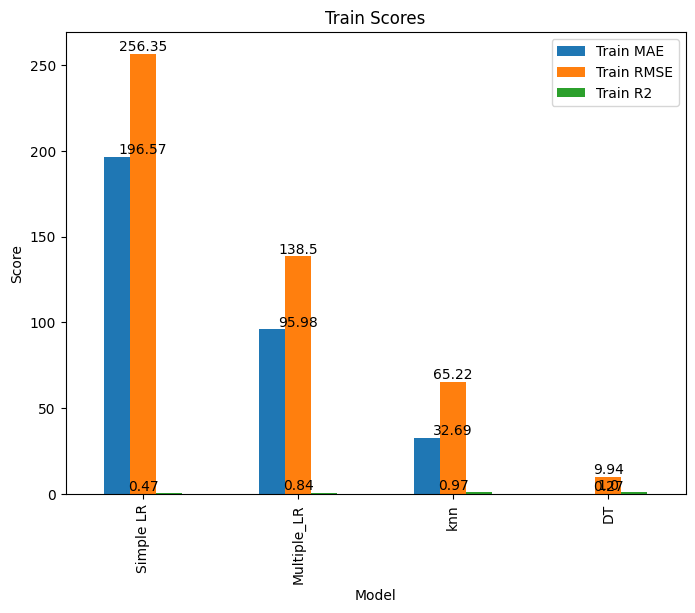

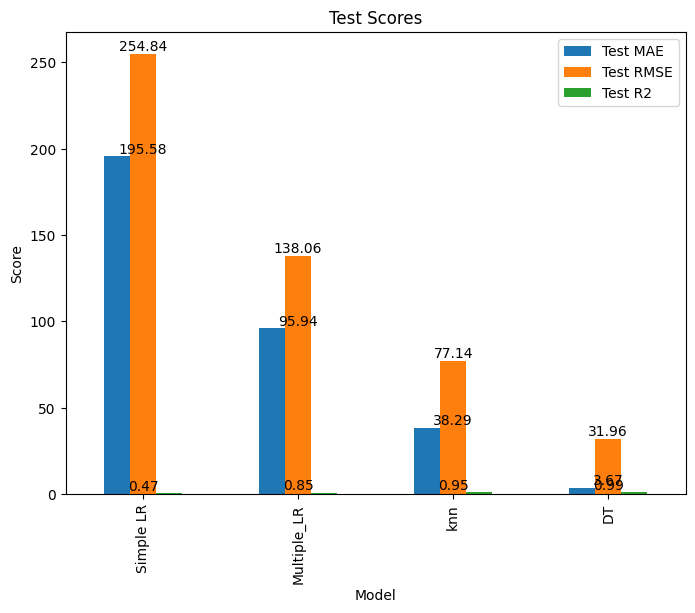

In [250]:
# Plot the train scores bar graph
train_plot = score_df[['Train MAE', 'Train RMSE', 'Train R2']].plot(kind='bar', figsize=(8,6))
train_plot.set_xlabel("Model")
train_plot.set_ylabel("Score")
train_plot.set_title("Train Scores")
for i, v in enumerate(score_df[['Train MAE', 'Train RMSE', 'Train R2']].values.flatten()):
    train_plot.annotate(str(round(v, 2)), xy=(i//3, v), ha='center', va='bottom')
# Plot the test scores bar graph
test_plot = score_df[['Test MAE', 'Test RMSE', 'Test R2']].plot(kind='bar', figsize=(8,6))
test_plot.set_xlabel("Model")
test_plot.set_ylabel("Score")
test_plot.set_title("Test Scores")
for i, v in enumerate(score_df[['Test MAE', 'Test RMSE', 'Test R2']].values.flatten()):
    test_plot.annotate(str(round(v, 2)), xy=(i//3, v), ha='center', va='bottom')
# Show the plots
plt.show()

From the above graphs we can infer that the train scores have less error as compare to test score. If we go with the model decision tree has the least error and high r2 value as compare to others. Followed by KNN model which has significant train and test score as compare to the other two regression models.